<a href="https://colab.research.google.com/github/ADean03/SmartSpace-AI-powered-wall-decoration-placement/blob/main/wallseg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [149]:
from matplotlib.pyplot import imshow

#from models.models import SegmentationModule, build_encoder, build_decoder
#from src.eval import segment_image
#from utils.constants import DEVICE
import os
import matplotlib.pyplot as plt
import random
import torch

from tqdm import tqdm  # progress bar
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import Dataset
from torch.utils.data import WeightedRandomSampler
import torchvision.ops as ops

In [150]:
pip install torchmetrics

In [151]:

from torch.utils.data import DataLoader
import torchvision.ops as ops
from torchmetrics.detection import IntersectionOverUnion

In [152]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!git clone https://github.com/ADean03/WallSegmentation.git

Cloning into 'WallSegmentation'...
remote: Enumerating objects: 356, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 356 (delta 32), reused 45 (delta 14), pack-reused 271 (from 1)
Receiving objects: 100% (356/356), 84.54 MiB | 18.93 MiB/s, done.
Resolving deltas: 100% (159/159), done.


In [ ]:
%cd WallSegmentation

/content/WallSegmentation


In [ ]:
%ls

ckpt/     LICENSE         README.md              src/             utils/
configs/  models/         readme_supplementary/  testing.ipynb
data/     model_weights/  requirements.txt       train_script.py


In [ ]:
!pip install -r requirements.txt

In [ ]:
from matplotlib.pyplot import imshow

from models.models import SegmentationModule, build_encoder, build_decoder
from src.eval import segment_image
from utils.constants import DEVICE

ModuleNotFoundError: No module named 'models'

In [ ]:
import os
file_path = '/content/drive/My Drive/SmartSpace'
os.listdir('/content/drive/MyDrive/SmartSpace')

['wallsegWeights',
 'homeobjects-3K',
 'visualizations',
 'YOLOWeights',
 'Copy of how-to-train-ultralytics-yolo-on-homeobjects-dataset.ipynb',
 'PaintingPredictor.ipynb',
 'wallseg.ipynb']

In [ ]:
#Testing getting segmented image

In [ ]:
file_path = '/content/drive/My Drive/SmartSpace/homeobjects-3K/images/train/living_room_1p (133).jpg'
print(os.path.exists(file_path))
#os.listdir('/content/drive/My Drive/SmartSpace/homeobjects-3K/images/train/living_room_1p (133).jpg')
#os.listdir('/content/drive/MyDrive/SmartSpace/wallsegWeights')

True


In [ ]:
path_image = file_path

# Model weights (encoder and decoder)
weights_encoder = '/content/drive/MyDrive/SmartSpace/wallsegWeights/best_encoder_epoch_19.pth'
weights_decoder = '/content/drive/MyDrive/SmartSpace/wallsegWeights/best_decoder_epoch_19.pth'

In [ ]:
net_encoder = build_encoder(weights_encoder)
net_decoder = build_decoder(weights_decoder)

segmentation_module = SegmentationModule(net_encoder, net_decoder)
segmentation_module = segmentation_module.to(DEVICE).eval()

Building encoder: resnet50-dilated
Loading weights for net_encoder
Loading weights for net_decoder


In [ ]:
segmentation_mask = segment_image(segmentation_module, path_image)

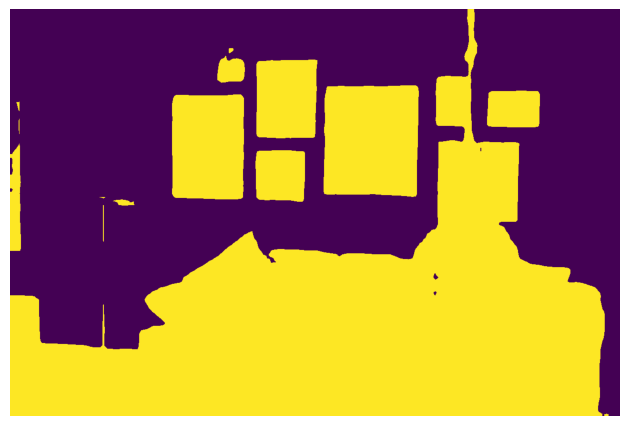

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(segmentation_mask)
plt.axis('off')        # hides the x/y axis
plt.tight_layout()     # removes padding
plt.show()

The image above was testing generating a binary wall/not mask. Ultimately this approach was not used as the not-wall mask has the painting/picture frames clearly outlined and while could theoritically could be removed based off existing bounding box data, simpiler approach would be to just predict based off bounding boxes

In [ ]:
print(type(segmentation_mask))
print(segmentation_mask.shape)
print(segmentation_mask.min(), segmentation_mask.max())

<class 'numpy.ndarray'>
(853, 1280)
0 1


In [ ]:
import os

label_dir = '/content/drive/My Drive/SmartSpace/homeobjects-3K/labels/train'

train_paintings_per_file = []  # list to store how many paintings are in each file

for label_file in os.listdir(label_dir):
    if not label_file.endswith('.txt'):
        continue
    label_path = os.path.join(label_dir, label_file)

    with open(label_path, 'r') as f:
        lines = f.readlines()
        count_paintings = 0
        for line in lines:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) == 0:
                continue
            class_id = int(parts[0])
            if class_id == 11:
                count_paintings += 1

        if count_paintings > 0:
            train_paintings_per_file.append(count_paintings)

train_num_files_with_paintings = len(train_paintings_per_file)
train_total_paintings = sum(train_paintings_per_file)
train_avg_paintings_per_file = train_total_paintings / train_num_files_with_paintings if train_num_files_with_paintings > 0 else 0

print(f"Found {train_num_files_with_paintings} images with paintings")
print(f"Average number of paintings per such image: {train_avg_paintings_per_file:.2f}")

Found 1062 images with paintings
Average number of paintings per such image: 2.56


In [ ]:
import os

label_dir = '/content/drive/My Drive/SmartSpace/homeobjects-3K/labels/val'

val_paintings_per_file = []  # list to store how many paintings are in each file

for label_file in os.listdir(label_dir):
    if not label_file.endswith('.txt'):
        continue
    label_path = os.path.join(label_dir, label_file)

    with open(label_path, 'r') as f:
        lines = f.readlines()
        count_paintings = 0
        for line in lines:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) == 0:
                continue
            class_id = int(parts[0])
            if class_id == 11:
                count_paintings += 1

        if count_paintings > 0:
            val_paintings_per_file.append(count_paintings)

val_num_files_with_paintings = len(val_paintings_per_file)
val_total_paintings = sum(val_paintings_per_file)
val_avg_paintings_per_file = val_total_paintings / val_num_files_with_paintings if val_num_files_with_paintings > 0 else 0

print(f"Found {val_num_files_with_paintings} images with paintings")
print(f"Average number of paintings per such image: {val_avg_paintings_per_file:.2f}")

Found 211 images with paintings
Average number of paintings per such image: 2.66


In [ ]:
import random

# Paths
base_dir = '/content/drive/My Drive/SmartSpace/homeobjects-3K/labels'
val_input_dir = os.path.join(base_dir, 'val_input')
val_input_aug_dir = os.path.join(base_dir, 'val_input_aug')

# Create the output folder if it doesn’t exist
os.makedirs(val_input_aug_dir, exist_ok=True)

for label_file in os.listdir(val_input_dir):
    if not label_file.endswith('.txt'):
        continue

    file_path = os.path.join(val_input_dir, label_file)

    with open(file_path, 'r') as f:
        lines = [l.strip() for l in f.readlines() if l.strip()]

    # Separate class 11 and other objects
    class11_lines = [l for l in lines if l.split()[0] == '11']
    other_lines = [l for l in lines if l.split()[0] != '11']

    # 1️⃣ Overwrite the original file (in val_input) with all class 11s removed
    with open(file_path, 'w') as f:
        for line in other_lines:
            f.write(line + '\n')

    # 2️⃣ If more than 2 paintings, create an augmented copy in val_input_aug
    if len(class11_lines) > 2:
        num_to_keep = random.randint(1, len(class11_lines) - 1)
        kept_class11 = random.sample(class11_lines, num_to_keep)

        new_lines = other_lines + kept_class11
        random.shuffle(new_lines)  # optional

        new_filename = label_file.replace('.txt', '_aug.txt')
        new_file_path = os.path.join(val_input_aug_dir, new_filename)

        with open(new_file_path, 'w') as f:
            for line in new_lines:
                f.write(line + '\n')

        print(f"Created augmented file: {new_filename} (kept {num_to_keep} of {len(class11_lines)})")

print("✅ Finished cleaning val_input and creating val_input_aug.")

Created augmented file: living_room_1p (143)_aug.txt (kept 1 of 4)
Created augmented file: living_room_1p (365)_aug.txt (kept 3 of 7)
Created augmented file: living_room_1p (218)_aug.txt (kept 5 of 8)
Created augmented file: living_room_1p (169)_aug.txt (kept 3 of 4)
Created augmented file: living_room_1p (260)_aug.txt (kept 1 of 3)
Created augmented file: living_room_1p (353)_aug.txt (kept 2 of 4)
Created augmented file: living_room_1p (131)_aug.txt (kept 5 of 6)
Created augmented file: living_room_1p (164)_aug.txt (kept 2 of 5)
Created augmented file: living_room_1p (160)_aug.txt (kept 2 of 3)
Created augmented file: living_room_1p (272)_aug.txt (kept 1 of 5)
Created augmented file: living_room_1p (35)_aug.txt (kept 1 of 7)
Created augmented file: living_room_1p (412)_aug.txt (kept 2 of 3)
Created augmented file: living_room_1p (3)_aug.txt (kept 2 of 3)
Created augmented file: living_room_1p (374)_aug.txt (kept 2 of 6)
Created augmented file: living_room_1p (101)_aug.txt (kept 1 of 3

In [ ]:
# Paths
base_dir = '/content/drive/My Drive/SmartSpace/homeobjects-3K/labels'
train_input_dir = os.path.join(base_dir, 'train_input')
train_input_aug_dir = os.path.join(base_dir, 'train_input_aug')

# Create the output folder if it doesn’t exist
os.makedirs(train_input_aug_dir, exist_ok=True)

for label_file in os.listdir(train_input_dir):
    if not label_file.endswith('.txt'):
        continue

    file_path = os.path.join(train_input_dir, label_file)

    with open(file_path, 'r') as f:
        lines = [l.strip() for l in f.readlines() if l.strip()]

    # Separate class 11 and other objects
    class11_lines = [l for l in lines if l.split()[0] == '11']
    other_lines = [l for l in lines if l.split()[0] != '11']

    # 1️⃣ Overwrite the original file (in train_input) with all class 11s removed
    with open(file_path, 'w') as f:
        for line in other_lines:
            f.write(line + '\n')

    # 2️⃣ If more than 2 paintings, create an augmented copy in train_input_aug
    if len(class11_lines) > 2:
        num_to_keep = random.randint(1, len(class11_lines) - 1)
        kept_class11 = random.sample(class11_lines, num_to_keep)

        new_lines = other_lines + kept_class11
        random.shuffle(new_lines)  # optional

        new_filename = label_file.replace('.txt', '_aug.txt')
        new_file_path = os.path.join(train_input_aug_dir, new_filename)

        with open(new_file_path, 'w') as f:
            for line in new_lines:
                f.write(line + '\n')

        print(f"Created augmented file: {new_filename} (kept {num_to_keep} of {len(class11_lines)})")

print("✅ Finished cleaning train_input and creating train_input_aug.")

Created augmented file: living_room_1320_aug.txt (kept 7 of 8)
Created augmented file: living_room_1237_aug.txt (kept 4 of 11)
Created augmented file: living_room_13_aug.txt (kept 1 of 3)
Created augmented file: living_room_133_aug.txt (kept 3 of 5)
Created augmented file: living_room_1303_aug.txt (kept 6 of 13)
Created augmented file: living_room_1302_aug.txt (kept 2 of 3)
Created augmented file: living_room_1291_aug.txt (kept 1 of 3)
Created augmented file: living_room_134_aug.txt (kept 2 of 3)
Created augmented file: living_room_1256_aug.txt (kept 4 of 5)
Created augmented file: living_room_1257_aug.txt (kept 2 of 3)
Created augmented file: living_room_1228_aug.txt (kept 6 of 7)
Created augmented file: living_room_1211_aug.txt (kept 1 of 3)
Created augmented file: living_room_1214_aug.txt (kept 1 of 3)
Created augmented file: living_room_121_aug.txt (kept 5 of 7)
Created augmented file: living_room_1208_aug.txt (kept 2 of 3)
Created augmented file: living_room_1192_aug.txt (kept 3 o

In [ ]:
#Model traing

In [153]:
base_dir = "/content/drive/My Drive/SmartSpace/homeobjects-3K/labels"

train_input_dir = "/content/drive/My Drive/SmartSpace/homeobjects-3K/labels/train_input"
train_input_aug_dir = "/content/drive/My Drive/SmartSpace/homeobjects-3K/labels/train_input_aug"
val_input_dir   = "/content/drive/My Drive/SmartSpace/homeobjects-3K/labels/val_input"
val_input_aug_dir = "/content/drive/My Drive/SmartSpace/homeobjects-3K/labels/val_input_aug"
train_target_dir = "/content/drive/My Drive/SmartSpace/homeobjects-3K/labels/train"
val_target_dir   = "/content/drive/My Drive/SmartSpace/homeobjects-3K/labels/val"

In [154]:
import os
import torch

from tqdm import tqdm  # progress bar

def load_labels(path):
    """Load bounding boxes from a YOLO-format label file."""
    boxes = []
    with open(path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                if len(parts) > 0:
                    print(f"⚠️ Skipped bad line in {path}: {parts}")
                continue
            cls, xc, yc, w, h = map(float, parts)
            boxes.append([int(cls), xc, yc, w, h])
    return torch.tensor(boxes) if boxes else torch.zeros((0,5))

def make_all_pairs(input_dir, target_dir, desc="Pairing files"):
    """
    Pairs every file in input_dir with the correct target in target_dir.
    Handles '_aug' filenames by stripping '_aug' to find the original target.
    Shows a progress bar with tqdm.
    """
    pairs = []
    files = [f for f in os.listdir(input_dir) if f.endswith(".txt")]

    for fname in tqdm(files, desc=desc):
        input_path = os.path.join(input_dir, fname)

        # If the file is an augmented file, strip '_aug' to find the original target
        target_fname = fname.replace("_aug", "") if "_aug" in fname else fname
        target_path = os.path.join(target_dir, target_fname)

        if os.path.exists(target_path):
            X = load_labels(input_path)
            Y = load_labels(target_path)
            pairs.append((X, Y))
        else:
            print(f"⚠️ Skipped {fname}, target {target_fname} not found in {target_dir}")

    return pairs

train_pairs = make_all_pairs(train_input_dir, train_target_dir, desc="Pairing train_input")
train_pairs += make_all_pairs(train_input_aug_dir, train_target_dir, desc="Pairing train_input_aug")

val_pairs = make_all_pairs(val_input_dir, val_target_dir, desc="Pairing val_input")
val_pairs += make_all_pairs(val_input_aug_dir, val_target_dir, desc="Pairing val_input_aug")

print(f"Loaded {len(train_pairs)} training pairs, {len(val_pairs)} validation pairs.")

Pairing val_input_aug: 100%|██████████| 73/73 [00:01<00:00, 69.08it/s]

Loaded 2601 training pairs, 477 validation pairs.


In [ ]:
print(f"Train pairs: {len(train_pairs)}")
print(f"Validation pairs: {len(val_pairs)}")

Train pairs: 2601
Validation pairs: 477


In [ ]:
for i, (X, Y) in enumerate(train_pairs[:10]):
    print(f"Train pair {i}: X={X.shape}, Y={Y.shape}")
for i, (X, Y) in enumerate(val_pairs[:10]):
    print(f"Val pair {i}: X={X.shape}, Y={Y.shape}")

Train pair 0: X=torch.Size([1, 5]), Y=torch.Size([1, 5])
Train pair 1: X=torch.Size([5, 5]), Y=torch.Size([5, 5])
Train pair 2: X=torch.Size([18, 5]), Y=torch.Size([19, 5])
Train pair 3: X=torch.Size([2, 5]), Y=torch.Size([2, 5])
Train pair 4: X=torch.Size([4, 5]), Y=torch.Size([4, 5])
Train pair 5: X=torch.Size([7, 5]), Y=torch.Size([7, 5])
Train pair 6: X=torch.Size([5, 5]), Y=torch.Size([6, 5])
Train pair 7: X=torch.Size([8, 5]), Y=torch.Size([9, 5])
Train pair 8: X=torch.Size([9, 5]), Y=torch.Size([11, 5])
Train pair 9: X=torch.Size([3, 5]), Y=torch.Size([5, 5])
Val pair 0: X=torch.Size([10, 5]), Y=torch.Size([10, 5])
Val pair 1: X=torch.Size([9, 5]), Y=torch.Size([10, 5])
Val pair 2: X=torch.Size([19, 5]), Y=torch.Size([19, 5])
Val pair 3: X=torch.Size([9, 5]), Y=torch.Size([13, 5])
Val pair 4: X=torch.Size([8, 5]), Y=torch.Size([10, 5])
Val pair 5: X=torch.Size([4, 5]), Y=torch.Size([4, 5])
Val pair 6: X=torch.Size([5, 5]), Y=torch.Size([5, 5])
Val pair 7: X=torch.Size([10, 5]), 

In [ ]:
import torch.nn.functional as F

def encode_objects(boxes, num_classes=12):
    feats = []
    for b in boxes:
        cls, xc, yc, w, h = b
        if cls == 11:  # skip picture frames
            continue
        onehot = F.one_hot(torch.tensor(int(cls)), num_classes=num_classes-1)
        feats.append(torch.cat([onehot.float(), torch.tensor([xc, yc, w, h])]))
    return torch.stack(feats) if feats else torch.zeros((1, num_classes+3))

In [ ]:
import torch.nn as nn

class SceneLayoutPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=4, num_pred=2):
        super().__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=8),
            num_layers=num_layers
        )
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.output_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 4 * num_pred)
        )
        self.num_pred = num_pred

    def forward(self, x):
        x = self.input_proj(x)
        x = self.encoder(x.unsqueeze(1)).squeeze(1)
        scene_feat = x.mean(0)
        preds = self.output_head(scene_feat)
        return preds.view(self.num_pred, 4)

In [ ]:
import torch.optim as optim
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

model = SceneLayoutPredictor(input_dim=15, num_pred=2).to(device)
opt = optim.Adam(model.parameters(), lr=1e-4)

def train_epoch(pairs):
    model.train()
    total_loss = 0
    for X, Y in pairs:
        X_enc = encode_objects(X).to(device)
        frame_boxes = Y[Y[:,0]==11][:,1:].to(device)
        if len(frame_boxes) == 0:
            continue

        preds = model(X_enc)
        target = torch.zeros_like(preds)
        target[:len(frame_boxes)] = frame_boxes[:preds.shape[0]]

        loss = F.smooth_l1_loss(preds, target)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item()

    return total_loss / len(pairs)

for epoch in range(20):
    loss = train_epoch(train_pairs)
    print(f"Epoch {epoch+1:02d} | Train loss: {loss:.4f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01 | Train loss: 0.0090
Epoch 02 | Train loss: 0.0086
Epoch 03 | Train loss: 0.0084
Epoch 04 | Train loss: 0.0084
Epoch 05 | Train loss: 0.0083
Epoch 06 | Train loss: 0.0081
Epoch 07 | Train loss: 0.0079
Epoch 08 | Train loss: 0.0078
Epoch 09 | Train loss: 0.0077
Epoch 10 | Train loss: 0.0074
Epoch 11 | Train loss: 0.0073
Epoch 12 | Train loss: 0.0070
Epoch 13 | Train loss: 0.0068
Epoch 14 | Train loss: 0.0066
Epoch 15 | Train loss: 0.0064
Epoch 16 | Train loss: 0.0061
Epoch 17 | Train loss: 0.0060
Epoch 18 | Train loss: 0.0057
Epoch 19 | Train loss: 0.0054
Epoch 20 | Train loss: 0.0052


In [ ]:
@torch.no_grad()
def evaluate(pairs):
    model.eval()
    total_loss = 0
    for X, Y in pairs:
        X_enc = encode_objects(X).to(device)
        frame_boxes = Y[Y[:,0]==11][:,1:].to(device)
        if len(frame_boxes) == 0:
            continue
        preds = model(X_enc)
        target = torch.zeros_like(preds)
        target[:len(frame_boxes)] = frame_boxes[:preds.shape[0]]
        loss = F.smooth_l1_loss(preds, target)
        total_loss += loss.item()
    return total_loss / len(pairs)

val_loss = evaluate(val_pairs)
print(f"Validation loss: {val_loss:.4f}")

Validation loss: 0.0129


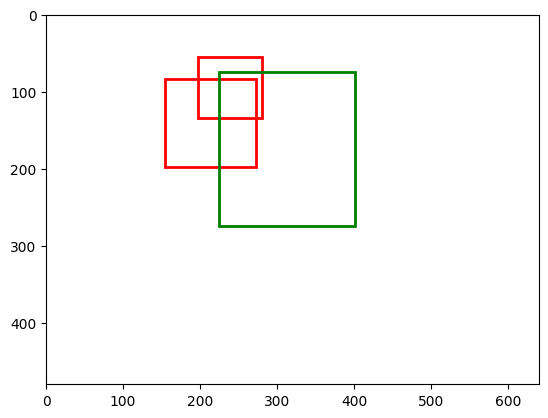

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_boxes(preds, targets, img_w=640, img_h=480):
    fig, ax = plt.subplots()
    preds = preds.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()

    for (x, y, w, h) in preds:
        ax.add_patch(patches.Rectangle(
            ((x - w/2) * img_w, (y - h/2) * img_h),
            w * img_w, h * img_h, edgecolor='r', facecolor='none', linewidth=2
        ))

    for (x, y, w, h) in targets:
        ax.add_patch(patches.Rectangle(
            ((x - w/2) * img_w, (y - h/2) * img_h),
            w * img_w, h * img_h, edgecolor='g', facecolor='none', linewidth=2
        ))

    # Set axes limits explicitly
    ax.set_xlim(0, img_w)
    ax.set_ylim(img_h, 0)  # invert y-axis for image coordinates
    ax.set_aspect('equal')
    plt.show()

# Example usage
X, Y = val_pairs[292]
preds = model(encode_objects(X).to(device)).cpu()
targets = Y[Y[:,0]==11][:,1:].cpu()
show_boxes(preds, targets)

Modifying original since it appeared to work the best, now weights samples towards ones with class 11 in them

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import WeightedRandomSampler
# --- Dataset wrapper for pairs ---

class PairDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        return self.pairs[idx]

train_dataset = PairDataset(train_pairs)

# --- Compute sample weights based on presence of class 11 (frames) ---

labels = []
for _, Y in train_pairs:
    has_frame = (Y[:,0] == 11).any().item()
    labels.append(1 if has_frame else 0)
labels = torch.tensor(labels)
class_counts = torch.bincount(labels)
weights_per_class = 1. / class_counts.float()
sample_weights = weights_per_class[labels]

# Create WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoader with sampler, batch size=1 as per your original single sample processing
train_loader = DataLoader(train_dataset, batch_size=1, sampler=sampler)

In [ ]:
# --- Encoding function ---

def encode_objects(boxes, num_classes=12):
    feats = []
    for b in boxes:
        cls, xc, yc, w, h = b
        if cls == 11:  # skip picture frames
            continue
        onehot = F.one_hot(torch.tensor(int(cls)), num_classes=num_classes-1)
        feats.append(torch.cat([onehot.float(), torch.tensor([xc, yc, w, h])]))
    return torch.stack(feats) if feats else torch.zeros((1, num_classes+3))

In [ ]:
# --- Model definition ---

class SceneLayoutPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=4, num_pred=2):
        super().__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=8),
            num_layers=num_layers
        )
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.output_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 4 * num_pred)
        )
        self.num_pred = num_pred

    def forward(self, x):
        x = self.input_proj(x)
        x = self.encoder(x.unsqueeze(1)).squeeze(1)
        scene_feat = x.mean(0)
        preds = self.output_head(scene_feat)
        return preds.view(self.num_pred, 4)

In [ ]:
# --- Setup device, model, optimizer ---

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SceneLayoutPredictor(input_dim=15, num_pred=2).to(device)
opt = optim.Adam(model.parameters(), lr=1e-4)

# --- Training loop using DataLoader with weighted sampling ---

def train_epoch_loader(loader):
    model.train()
    total_loss = 0
    for X, Y in loader:
        X_enc = encode_objects(X[0]).to(device)
        frame_boxes = Y[0][Y[0][:,0]==11][:,1:].to(device)
        if len(frame_boxes) == 0:
            continue
        preds = model(X_enc)
        target = torch.zeros_like(preds)
        target[:len(frame_boxes)] = frame_boxes[:preds.shape[0]]
        loss = F.smooth_l1_loss(preds, target)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item()
    return total_loss / len(loader)


In [ ]:
# --- Validation function, unchanged ---

@torch.no_grad()
def evaluate(pairs):
    model.eval()
    total_loss = 0
    for X, Y in pairs:
        X_enc = encode_objects(X).to(device)
        frame_boxes = Y[Y[:,0]==11][:,1:].to(device)
        if len(frame_boxes) == 0:
            continue
        preds = model(X_enc)
        target = torch.zeros_like(preds)
        target[:len(frame_boxes)] = frame_boxes[:preds.shape[0]]
        loss = F.smooth_l1_loss(preds, target)
        total_loss += loss.item()
    return total_loss / len(pairs)

In [ ]:
# --- Training execution ---

for epoch in range(20):
    loss = train_epoch_loader(train_loader)
    print(f"Epoch {epoch+1:02d} | Train loss: {loss:.4f}")

val_loss = evaluate(val_pairs)
print(f"Validation loss: {val_loss:.4f}")



Epoch 01 | Train loss: 0.0087
Epoch 02 | Train loss: 0.0079
Epoch 03 | Train loss: 0.0082
Epoch 04 | Train loss: 0.0081
Epoch 05 | Train loss: 0.0082
Epoch 06 | Train loss: 0.0079
Epoch 07 | Train loss: 0.0079
Epoch 08 | Train loss: 0.0076
Epoch 09 | Train loss: 0.0077
Epoch 10 | Train loss: 0.0071
Epoch 11 | Train loss: 0.0070
Epoch 12 | Train loss: 0.0067
Epoch 13 | Train loss: 0.0068
Epoch 14 | Train loss: 0.0067
Epoch 15 | Train loss: 0.0066
Epoch 16 | Train loss: 0.0060
Epoch 17 | Train loss: 0.0058
Epoch 18 | Train loss: 0.0059
Epoch 19 | Train loss: 0.0052
Epoch 20 | Train loss: 0.0056
Validation loss: 0.0121


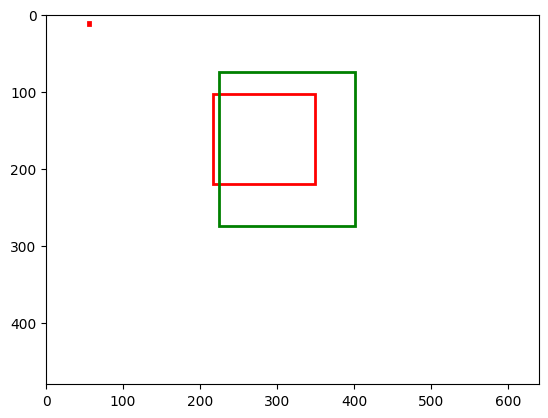

In [ ]:
# --- Visualization ---

def show_boxes(preds, targets, img_w=640, img_h=480):
    fig, ax = plt.subplots()
    preds = preds.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()

    for (x, y, w, h) in preds:
        ax.add_patch(patches.Rectangle(
            ((x - w/2) * img_w, (y - h/2) * img_h),
            w * img_w, h * img_h, edgecolor='r', facecolor='none', linewidth=2
        ))

    for (x, y, w, h) in targets:
        ax.add_patch(patches.Rectangle(
            ((x - w/2) * img_w, (y - h/2) * img_h),
            w * img_w, h * img_h, edgecolor='g', facecolor='none', linewidth=2
        ))

    ax.set_xlim(0, img_w)
    ax.set_ylim(img_h, 0)
    ax.set_aspect('equal')
    plt.show()

# Example prediction visualization
X, Y = val_pairs[292]
preds = model(encode_objects(X).to(device)).cpu()
targets = Y[Y[:,0]==11][:,1:].cpu()
show_boxes(preds, targets)

Modifying to attempt predictions for variable number of paintings. Note large number of paintings usually result in smaller size of them in train/val sets

Current method always prediciting 10 paintings per, but filtering them based on cofidence thresholds and then removing overlapping ones

In [ ]:
class SceneLayoutPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=4, num_pred=10):
        super().__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=8),
            num_layers=num_layers
        )
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.output_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 5 * num_pred)  # 4 box coords + 1 confidence
        )
        self.num_pred = num_pred

    def forward(self, x):
        x = self.input_proj(x)
        x = self.encoder(x.unsqueeze(1)).squeeze(1)
        scene_feat = x.mean(0)
        preds = self.output_head(scene_feat)
        preds = preds.view(self.num_pred, 5)
        boxes = preds[:, :4]
        confidences = torch.sigmoid(preds[:, 4])
        return boxes, confidences


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SceneLayoutPredictor(input_dim=15, num_pred=10).to(device)
opt = optim.Adam(model.parameters(), lr=1e-4)

# --- Loss function ---

def compute_loss(pred_boxes, pred_conf, target_boxes):
    # Simplified loss: match pred boxes to targets by index (limit to targets or pred count)
    n = min(len(target_boxes), pred_boxes.size(0))
    if n == 0:
        # No target frames, encourage confidence to zero
        conf_loss = F.binary_cross_entropy(pred_conf, torch.zeros_like(pred_conf))
        box_loss = torch.tensor(0., device=pred_boxes.device)
    else:
        conf_target = torch.zeros_like(pred_conf)
        conf_target[:n] = 1.0
        conf_loss = F.binary_cross_entropy(pred_conf, conf_target)
        box_loss = F.smooth_l1_loss(pred_boxes[:n], target_boxes[:n])
    return conf_loss + box_loss

In [ ]:
# --- Training function ---

def train_epoch_loader(loader):
    model.train()
    total_loss = 0
    for X, Y in loader:
        X_enc = encode_objects(X[0]).to(device)
        frame_boxes = Y[0][Y[0][:,0] == 11][:, 1:].to(device)
        opt.zero_grad()
        pred_boxes, pred_conf = model(X_enc)
        loss = compute_loss(pred_boxes, pred_conf, frame_boxes)
        loss.backward()
        opt.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# --- Validation function (no sampling) ---

@torch.no_grad()
def evaluate(pairs):
    model.eval()
    total_loss = 0
    for X, Y in pairs:
        X_enc = encode_objects(X).to(device)
        frame_boxes = Y[Y[:,0] == 11][:, 1:].to(device)
        pred_boxes, pred_conf = model(X_enc)
        loss = compute_loss(pred_boxes, pred_conf, frame_boxes)
        total_loss += loss.item()
    return total_loss / len(pairs)

In [ ]:
 #--- Inference helper with confidence threshold and NMS ---

def inference_with_nms(model, X_enc, conf_thresh=0.5, nms_thresh=0.4):
    model.eval()
    with torch.no_grad():
        boxes, confidences = model(X_enc)
        keep = confidences > conf_thresh
        if keep.sum() == 0:
            return torch.empty((0,4), device=X_enc.device)
        boxes = boxes[keep]
        scores = confidences[keep]
        x1 = boxes[:,0] - boxes[:,2]/2
        y1 = boxes[:,1] - boxes[:,3]/2
        x2 = boxes[:,0] + boxes[:,2]/2
        y2 = boxes[:,1] + boxes[:,3]/2
        boxes_xyxy = torch.stack([x1, y1, x2, y2], dim=1)
        keep_indices = ops.nms(boxes_xyxy, scores, nms_thresh)
        return boxes[keep_indices]

In [ ]:
# --- Training loop ---

for epoch in range(20):
    train_loss = train_epoch_loader(train_loader)
    val_loss = evaluate(val_pairs)
    print(f"Epoch {epoch+1:02d} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f}")


Epoch 01 | Train loss: 0.3642 | Val loss: 0.3843
Epoch 02 | Train loss: 0.3469 | Val loss: 0.3894
Epoch 03 | Train loss: 0.3442 | Val loss: 0.4343
Epoch 04 | Train loss: 0.3535 | Val loss: 0.3934
Epoch 05 | Train loss: 0.3470 | Val loss: 0.3899
Epoch 06 | Train loss: 0.3427 | Val loss: 0.3946
Epoch 07 | Train loss: 0.3394 | Val loss: 0.4073
Epoch 08 | Train loss: 0.3525 | Val loss: 0.4019
Epoch 09 | Train loss: 0.3569 | Val loss: 0.3946
Epoch 10 | Train loss: 0.3432 | Val loss: 0.4021
Epoch 11 | Train loss: 0.3462 | Val loss: 0.3948
Epoch 12 | Train loss: 0.3440 | Val loss: 0.3892
Epoch 13 | Train loss: 0.3484 | Val loss: 0.3875
Epoch 14 | Train loss: 0.3269 | Val loss: 0.3918
Epoch 15 | Train loss: 0.3522 | Val loss: 0.3959
Epoch 16 | Train loss: 0.3391 | Val loss: 0.4033
Epoch 17 | Train loss: 0.3585 | Val loss: 0.3923
Epoch 18 | Train loss: 0.3378 | Val loss: 0.3987
Epoch 19 | Train loss: 0.3434 | Val loss: 0.3994
Epoch 20 | Train loss: 0.3648 | Val loss: 0.3885


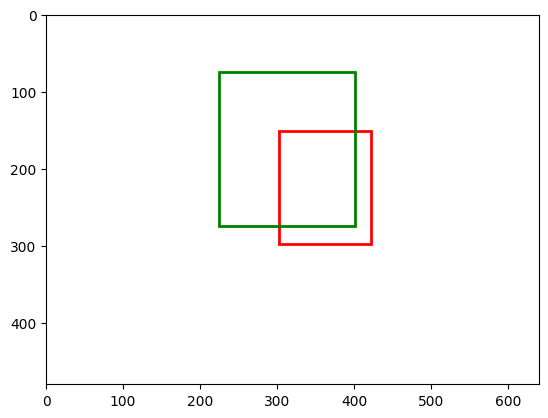

In [ ]:
# --- Visualization (unchanged) ---
import torchvision.ops as ops


def show_boxes(preds, targets, img_w=640, img_h=480):
    fig, ax = plt.subplots()
    preds = preds.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()
    for (x, y, w, h) in preds:
        ax.add_patch(patches.Rectangle(
            ((x - w/2) * img_w, (y - h/2) * img_h),
            w * img_w, h * img_h, edgecolor='r', facecolor='none', linewidth=2))
    for (x, y, w, h) in targets:
        ax.add_patch(patches.Rectangle(
            ((x - w/2) * img_w, (y - h/2) * img_h),
            w * img_w, h * img_h, edgecolor='g', facecolor='none', linewidth=2))
    ax.set_xlim(0, img_w)
    ax.set_ylim(img_h, 0)
    ax.set_aspect('equal')
    plt.show()

X, Y = val_pairs[292]
X_enc = encode_objects(X).to(device)
predicted_boxes = inference_with_nms(model, X_enc, conf_thresh=0.5, nms_thresh=0.4)
target_boxes = Y[Y[:,0] == 11][:, 1:].to(device)
show_boxes(predicted_boxes, target_boxes)

Updating to IoU, ran with 20 num_pred

In [ ]:
pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 16.3 MB/s eta 0:00:00


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.ops as ops
from torchmetrics.detection import IntersectionOverUnion
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
# --- Dataset wrapper ---

class PairDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        return self.pairs[idx]

train_dataset = PairDataset(train_pairs)

# --- Sample weights for imbalance handling ---

labels = []
for _, Y in train_pairs:
    has_frame = (Y[:,0] == 11).any().item()
    labels.append(1 if has_frame else 0)

labels = torch.tensor(labels)
class_counts = torch.bincount(labels)
weights_per_class = 1. / class_counts.float()
sample_weights = weights_per_class[labels]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
train_loader = DataLoader(train_dataset, batch_size=1, sampler=sampler)

# --- Encoding objects ---

def encode_objects(boxes, num_classes=12):
    feats = []
    for b in boxes:
        cls, xc, yc, w, h = b
        if cls == 11:
            continue
        onehot = F.one_hot(torch.tensor(int(cls)), num_classes=num_classes-1)
        feats.append(torch.cat([onehot.float(), torch.tensor([xc, yc, w, h])]))
    return torch.stack(feats) if feats else torch.zeros((1, num_classes+3))

In [ ]:
# --- Model with boxes + confidence ---

class SceneLayoutPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=4, num_pred=20):
        super().__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=8),
            num_layers=num_layers
        )
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.output_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 5 * num_pred)  # 4 coords + 1 conf
        )
        self.num_pred = num_pred

    def forward(self, x):
        x = self.input_proj(x)
        x = self.encoder(x.unsqueeze(1)).squeeze(1)
        scene_feat = x.mean(0)
        preds = self.output_head(scene_feat).view(self.num_pred, 5)
        boxes = preds[:, :4]
        confidences = torch.sigmoid(preds[:, 4])
        return boxes, confidences


In [ ]:
# --- Setup model, optimizer, device ---

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SceneLayoutPredictor(input_dim=15, num_pred=20).to(device)
opt = optim.Adam(model.parameters(), lr=1e-4)

# --- Loss function combining box regression & confidence ---

def compute_loss(pred_boxes, pred_conf, target_boxes):
    n = min(len(target_boxes), pred_boxes.size(0))
    if n == 0:
        conf_loss = F.binary_cross_entropy(pred_conf, torch.zeros_like(pred_conf))
        box_loss = torch.tensor(0., device=pred_boxes.device)
    else:
        conf_target = torch.zeros_like(pred_conf)
        conf_target[:n] = 1.0
        conf_loss = F.binary_cross_entropy(pred_conf, conf_target)
        box_loss = F.smooth_l1_loss(pred_boxes[:n], target_boxes[:n])
    return conf_loss + box_loss

In [ ]:
# --- IoU metric ---

iou_metric = IntersectionOverUnion(box_format='xyxy')

def boxes_cxcywh_to_xyxy(boxes):
    cx, cy, w, h = boxes.unbind(-1)
    return torch.stack([cx - w/2, cy - h/2, cx + w/2, cy + h/2], dim=-1)

In [ ]:
# --- Training epoch ---

def train_epoch_loader(loader):
    model.train()
    total_loss = 0
    for X, Y in loader:
        X_enc = encode_objects(X[0]).to(device)
        frame_boxes = Y[0][Y[0][:,0] == 11][:,1:].to(device)
        opt.zero_grad()
        pred_boxes, pred_conf = model(X_enc)
        loss = compute_loss(pred_boxes, pred_conf, frame_boxes)
        loss.backward()
        opt.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# --- Validation with IoU ---

@torch.no_grad()
def evaluate_with_iou(pairs):
    model.eval()
    total_loss = 0
    iou_metric.reset()
    for X, Y in pairs:
        X_enc = encode_objects(X).to(device)
        target_boxes = Y[Y[:,0] == 11][:,1:].to(device)

        pred_boxes, pred_conf = model(X_enc)
        conf_thresh = 0.5
        nms_thresh = 0.4
        keep = pred_conf > conf_thresh
        if keep.sum() == 0:
            continue
        pred_boxes = pred_boxes[keep]

        # NMS requires xyxy boxes
        boxes_xyxy = boxes_cxcywh_to_xyxy(pred_boxes)
        scores = pred_conf[keep]
        keep_indices = ops.nms(boxes_xyxy, scores, nms_thresh)
        pred_boxes = pred_boxes[keep_indices]

        target_boxes_xyxy = boxes_cxcywh_to_xyxy(target_boxes)
        pred_boxes_xyxy = boxes_cxcywh_to_xyxy(pred_boxes)

        preds = [{'boxes': pred_boxes_xyxy, 'labels': torch.zeros(len(pred_boxes_xyxy), dtype=torch.int, device=device)}]
        targets = [{'boxes': target_boxes_xyxy, 'labels': torch.zeros(len(target_boxes_xyxy), dtype=torch.int, device=device)}]

        iou_metric.update(preds, targets)

        loss = compute_loss(pred_boxes, pred_conf[keep][keep_indices], target_boxes)
        total_loss += loss.item()

    mean_iou = iou_metric.compute()['iou'].item()
    avg_loss = total_loss / len(pairs)
    return avg_loss, mean_iou

In [ ]:
# --- Training loop ---

for epoch in range(20):
    train_loss = train_epoch_loader(train_loader)
    val_loss, val_iou = evaluate_with_iou(val_pairs)
    print(f"Epoch {epoch+1:02d} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f} | Val mean IoU: {val_iou:.4f}")


Epoch 01 | Train loss: 0.2149 | Val loss: 0.3720 | Val mean IoU: 0.0309
Epoch 02 | Train loss: 0.2062 | Val loss: 0.0896 | Val mean IoU: 0.0174
Epoch 03 | Train loss: 0.2011 | Val loss: 0.2685 | Val mean IoU: 0.0220
Epoch 04 | Train loss: 0.1906 | Val loss: 0.4728 | Val mean IoU: 0.0244
Epoch 05 | Train loss: 0.2000 | Val loss: 0.2603 | Val mean IoU: 0.0294
Epoch 06 | Train loss: 0.1971 | Val loss: 0.5726 | Val mean IoU: 0.0230
Epoch 07 | Train loss: 0.2023 | Val loss: 0.6243 | Val mean IoU: 0.0297
Epoch 08 | Train loss: 0.1970 | Val loss: 0.3955 | Val mean IoU: 0.0242
Epoch 09 | Train loss: 0.1898 | Val loss: 0.0162 | Val mean IoU: 0.0166
Epoch 10 | Train loss: 0.2061 | Val loss: 0.5417 | Val mean IoU: 0.0316
Epoch 11 | Train loss: 0.1858 | Val loss: 0.2819 | Val mean IoU: 0.0284
Epoch 12 | Train loss: 0.2000 | Val loss: 0.3262 | Val mean IoU: 0.0347
Epoch 13 | Train loss: 0.1912 | Val loss: 0.3948 | Val mean IoU: 0.0303
Epoch 14 | Train loss: 0.1988 | Val loss: 0.3371 | Val mean IoU:

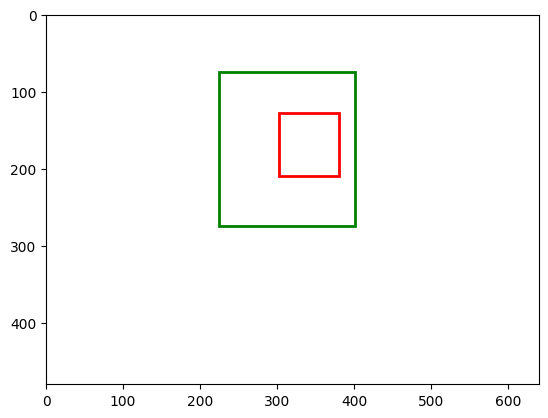

In [ ]:
# --- Visualization ---

def show_boxes(preds, targets, img_w=640, img_h=480):
    fig, ax = plt.subplots()
    preds = preds.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()
    for (x, y, w, h) in preds:
        ax.add_patch(patches.Rectangle(
            ((x - w/2) * img_w, (y - h/2) * img_h),
            w * img_w, h * img_h, edgecolor='r', facecolor='none', linewidth=2))
    for (x, y, w, h) in targets:
        ax.add_patch(patches.Rectangle(
            ((x - w/2) * img_w, (y - h/2) * img_h),
            w * img_w, h * img_h, edgecolor='g', facecolor='none', linewidth=2))
    ax.set_xlim(0, img_w)
    ax.set_ylim(img_h, 0)
    ax.set_aspect('equal')
    plt.show()

    # --- Example prediction visualization---

X, Y = val_pairs[292]
X_enc = encode_objects(X).to(device)
pred_boxes, pred_conf = model(X_enc)

# Apply confidence threshold and NMS for visualization
conf_thresh = 0.5
nms_thresh = 0.4
keep = pred_conf > conf_thresh
pred_boxes = pred_boxes[keep]
scores = pred_conf[keep]

boxes_xyxy = boxes_cxcywh_to_xyxy(pred_boxes)
keep_indices = ops.nms(boxes_xyxy, scores, nms_thresh)
pred_boxes = pred_boxes[keep_indices]

target_boxes = Y[Y[:,0]==11][:,1:].to(device)

show_boxes(pred_boxes, target_boxes)

Updating loss to CIoU + smoothL1, IoU NMS, adding Explicit Box Matching, further increasing weight of class 11

In [156]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.ops import box_iou, nms, complete_box_iou_loss
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import ops

# --- Dataset wrapper ---
class PairDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        return self.pairs[idx]

train_dataset = PairDataset(train_pairs)

# --- Sample weights for imbalance handling ---
labels = []
for _, Y in train_pairs:
    has_frame = (Y[:,0] == 11).any().item()
    labels.append(1 if has_frame else 0)

labels = torch.tensor(labels)
class_counts = torch.bincount(labels)
weights_per_class = 1. / class_counts.float()
weights_per_class[1] *= 3  # 3x weight for painting-containing samples (label=1)
sample_weights = weights_per_class[labels]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
train_loader = DataLoader(train_dataset, batch_size=1, sampler=sampler)

In [157]:
# --- Encoding objects ---
def encode_objects(boxes, num_classes=12):
    feats = []
    for b in boxes:
        cls, xc, yc, w, h = b
        if cls == 11:
            continue
        onehot = F.one_hot(torch.tensor(int(cls)), num_classes=num_classes-1)
        feats.append(torch.cat([onehot.float(), torch.tensor([xc, yc, w, h])]))
    return torch.stack(feats) if feats else torch.zeros((1, num_classes+3))


In [158]:
# --- Model with boxes + confidence ---
class SceneLayoutPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=4, num_pred=20):
        super().__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=8),
            num_layers=num_layers
        )
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.output_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 5 * num_pred)  # 4 coords + 1 conf
        )
        self.num_pred = num_pred

    def forward(self, x):
        x = self.input_proj(x)
        x = self.encoder(x.unsqueeze(1)).squeeze(1)
        scene_feat = x.mean(0)
        preds = self.output_head(scene_feat).view(self.num_pred, 5)
        boxes = preds[:, :4]
        confidences = torch.sigmoid(preds[:, 4])
        return boxes, confidences

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SceneLayoutPredictor(input_dim=15, num_pred=20).to(device)
opt = optim.Adam(model.parameters(), lr=1e-4)

In [163]:
# --- Utility functions ---
def boxes_cxcywh_to_xyxy(boxes):
    cx, cy, w, h = boxes.unbind(-1)
    return torch.stack([cx - w/2, cy - h/2, cx + w/2, cy + h/2], dim=-1)

def ciou_nms(boxes, scores, iou_threshold=0.4):
    # Actually standard IoU NMS cause CIoU NMS very complicated apparently
    return nms(boxes, scores, iou_threshold)

In [160]:
# --- Loss with explicit Hungarian matching + Smooth L1 + CIoU ---
def compute_loss(pred_boxes, pred_conf, target_boxes):
    num_pred = pred_boxes.size(0)
    num_target = target_boxes.size(0)
    if num_target == 0:
        conf_loss = F.binary_cross_entropy(pred_conf, torch.zeros_like(pred_conf))
        box_loss = torch.tensor(0., device=pred_boxes.device)
        return conf_loss + box_loss

    pred_xyxy = boxes_cxcywh_to_xyxy(pred_boxes)
    target_xyxy = boxes_cxcywh_to_xyxy(target_boxes)

    with torch.no_grad():
        iou_matrix = box_iou(pred_xyxy, target_xyxy)  # [num_pred, num_target]
        cost_matrix = 1 - iou_matrix.cpu().numpy()
        row_ind, col_ind = linear_sum_assignment(cost_matrix)

    matched_pred_boxes = pred_boxes[row_ind]
    matched_pred_conf = pred_conf[row_ind]
    matched_target_boxes = target_boxes[col_ind]

    conf_target = torch.zeros_like(pred_conf)
    conf_target[row_ind] = 1.0

    conf_loss = F.binary_cross_entropy(pred_conf, conf_target)

    smooth_l1_loss = F.smooth_l1_loss(matched_pred_boxes, matched_target_boxes)

    ciou_loss = complete_box_iou_loss(
        boxes_cxcywh_to_xyxy(matched_pred_boxes),
        boxes_cxcywh_to_xyxy(matched_target_boxes),
        reduction='mean'
    )

    box_loss = 0.5 * smooth_l1_loss + 0.5 * ciou_loss

    return conf_loss + box_loss

In [169]:
#debugging loss function
def compute_loss(pred_boxes, pred_conf, target_boxes):
    num_pred = pred_boxes.size(0)
    num_target = target_boxes.size(0)
    if num_target == 0:
        conf_loss = F.binary_cross_entropy(pred_conf, torch.zeros_like(pred_conf))
        box_loss = torch.tensor(0., device=pred_boxes.device)
        print(f"No targets: conf_loss={conf_loss.item()}, box_loss={box_loss.item()}")
        return conf_loss + box_loss

    pred_xyxy = boxes_cxcywh_to_xyxy(pred_boxes)
    target_xyxy = boxes_cxcywh_to_xyxy(target_boxes)

    with torch.no_grad():
        iou_matrix = box_iou(pred_xyxy, target_xyxy)  # [num_pred, num_target]
        cost_matrix = 1 - iou_matrix.cpu().numpy()
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
    print(f"Hungarian matching: row_ind={row_ind}, col_ind={col_ind}")

    matched_pred_boxes = pred_boxes[row_ind]
    matched_pred_conf = pred_conf[row_ind]
    matched_target_boxes = target_boxes[col_ind]

    conf_target = torch.zeros_like(pred_conf)
    conf_target[row_ind] = 1.0

    conf_loss = F.binary_cross_entropy(pred_conf, conf_target)

    smooth_l1_loss = F.smooth_l1_loss(matched_pred_boxes, matched_target_boxes)

    ciou_loss = complete_box_iou_loss(
        boxes_cxcywh_to_xyxy(matched_pred_boxes),
        boxes_cxcywh_to_xyxy(matched_target_boxes),
        reduction='mean'
    )

    box_loss = 0.5 * smooth_l1_loss + 0.5 * ciou_loss

    print(f"conf_loss: {conf_loss.item()}, smooth_l1_loss: {smooth_l1_loss.item()}, ciou_loss: {ciou_loss.item()}, box_loss: {box_loss.item()}")

    return conf_loss + box_loss

In [167]:
# --- Training epoch ---
def train_epoch_loader(loader):
    model.train()
    total_loss = 0
    for X, Y in loader:
        X_enc = encode_objects(X[0]).to(device)
        frame_boxes = Y[0][Y[0][:,0] == 11][:,1:].to(device)
        opt.zero_grad()
        pred_boxes, pred_conf = model(X_enc)
        loss = compute_loss(pred_boxes, pred_conf, frame_boxes)
        loss.backward()
        opt.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# --- Validation with IoU ---
iou_metric = IntersectionOverUnion(box_format='xyxy')
@torch.no_grad()
def evaluate_with_iou(pairs):
    model.eval()
    total_loss = 0
    iou_metric.reset()  # <-- reset here before processing all samples
    updated = False

    for X, Y in pairs:
        X_enc = encode_objects(X).to(device)
        target_boxes = Y[Y[:,0] == 11][:,1:].to(device)

        pred_boxes, pred_conf = model(X_enc)
        conf_thresh = 0.5
        nms_thresh = 0.4
        keep = pred_conf > conf_thresh
        if keep.sum() == 0:
            continue
        pred_boxes = pred_boxes[keep]
        scores = pred_conf[keep]

        boxes_xyxy = boxes_cxcywh_to_xyxy(pred_boxes)
        keep_indices = ciou_nms(boxes_xyxy, scores, nms_thresh)
        pred_boxes = pred_boxes[keep_indices]

        target_boxes_xyxy = boxes_cxcywh_to_xyxy(target_boxes)
        pred_boxes_xyxy = boxes_cxcywh_to_xyxy(pred_boxes)

        preds = [{'boxes': pred_boxes_xyxy, 'labels': torch.zeros(len(pred_boxes_xyxy), dtype=torch.int, device=device)}]
        targets = [{'boxes': target_boxes_xyxy, 'labels': torch.zeros(len(target_boxes_xyxy), dtype=torch.int, device=device)}]

        iou_metric.update(preds, targets)
        updated = True

        loss = compute_loss(pred_boxes, pred_conf[keep][keep_indices], target_boxes)
        total_loss += loss.item()

    if not updated:
        mean_iou = 0.0
    else:
        mean_iou = iou_metric.compute()['iou'].item()


    avg_loss = total_loss / len(pairs)
    return avg_loss, mean_iou


In [170]:
#Train debug
def train_epoch_loader(loader):
    model.train()
    total_loss = 0
    for i, (X, Y) in enumerate(loader):
        X_enc = encode_objects(X[0]).to(device)
        frame_boxes = Y[0][Y[0][:,0] == 11][:,1:].to(device)
        opt.zero_grad()
        pred_boxes, pred_conf = model(X_enc)
        loss = compute_loss(pred_boxes, pred_conf, frame_boxes)
        loss.backward()

        # Check gradients stats
        for name, param in model.named_parameters():
            if param.grad is None:
                print(f"No grad for {name}")
            else:
                print(f"Grad stats for {name}: mean={param.grad.mean().item()}, std={param.grad.std().item()}")

        opt.step()
        total_loss += loss.item()

        if i % 10 == 0:  # Print every 10 batches
            print(f"Batch {i}, Loss: {loss.item()}")
    return total_loss / len(loader)

In [171]:
# --- Training loop ---
for epoch in range(20):
    train_loss = train_epoch_loader(train_loader)
    val_loss, val_iou = evaluate_with_iou(val_pairs)
    print(f"Epoch {epoch+1:02d} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f} | Val mean IoU: {val_iou:.4f}")


Streaming output truncated to the last 5000 lines.
Grad stats for encoder.layers.1.norm1.bias: mean=-4.756593341426196e-08, std=1.6097793604785693e-06
Grad stats for encoder.layers.1.norm2.weight: mean=3.476543497527018e-09, std=6.761812983313575e-06
Grad stats for encoder.layers.1.norm2.bias: mean=-2.081568197809247e-07, std=7.079179795255186e-06
Grad stats for encoder.layers.2.self_attn.in_proj_weight: mean=-9.442461396114155e-11, std=2.1450186977745034e-06
Grad stats for encoder.layers.2.self_attn.in_proj_bias: mean=-1.7213596947840415e-07, std=2.2209540020412533e-06
Grad stats for encoder.layers.2.self_attn.out_proj.weight: mean=-7.404652890841135e-09, std=6.8464610194496345e-06
Grad stats for encoder.layers.2.self_attn.out_proj.bias: mean=-7.495484055652923e-08, std=5.367618086893344e-06
Grad stats for encoder.layers.2.linear1.weight: mean=-6.899286697503726e-12, std=1.842588744693785e-06
Grad stats for encoder.layers.2.linear1.bias: mean=5.513905332321656e-09, std=1.8981226048708

KeyboardInterrupt: 

In [162]:
# --- Visualization ---
def show_boxes(preds, targets, img_w=640, img_h=480):
    fig, ax = plt.subplots()
    preds = preds.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()
    for (x, y, w, h) in preds:
        ax.add_patch(patches.Rectangle(
            ((x - w/2) * img_w, (y - h/2) * img_h),
            w * img_w, h * img_h, edgecolor='r', facecolor='none', linewidth=2))
    for (x, y, w, h) in targets:
        ax.add_patch(patches.Rectangle(
            ((x - w/2) * img_w, (y - h/2) * img_h),
            w * img_w, h * img_h, edgecolor='g', facecolor='none', linewidth=2))
    ax.set_xlim(0, img_w)
    ax.set_ylim(img_h, 0)
    ax.set_aspect('equal')
    plt.show()

    # --- Example prediction visualization---
X, Y = val_pairs[292]
X_enc = encode_objects(X).to(device)
pred_boxes, pred_conf = model(X_enc)
conf_thresh = 0.5
nms_thresh = 0.4
keep = pred_conf > conf_thresh
pred_boxes = pred_boxes[keep]
scores = pred_conf[keep]
boxes_xyxy = boxes_cxcywh_to_xyxy(pred_boxes)
keep_indices = ciou_nms(boxes_xyxy, scores, nms_thresh)
pred_boxes = pred_boxes[keep_indices]
target_boxes = Y[Y[:,0]==11][:,1:].to(device)
show_boxes(pred_boxes, target_boxes)

Using GIoU #Currently not working

In [ ]:
from torchvision.ops import generalized_box_iou_loss
# --- Dataset wrapper ---

class PairDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        return self.pairs[idx]

train_dataset = PairDataset(train_pairs)

# --- Weighted sampling ---

labels = []
for _, Y in train_pairs:
    has_frame = (Y[:,0] == 11).any().item()
    labels.append(1 if has_frame else 0)

labels = torch.tensor(labels)
class_counts = torch.bincount(labels)
weights_per_class = 1. / class_counts.float()
sample_weights = weights_per_class[labels]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
train_loader = DataLoader(train_dataset, batch_size=1, sampler=sampler)

# --- Encoding ---

def encode_objects(boxes, num_classes=12):
    feats = []
    for b in boxes:
        cls, xc, yc, w, h = b
        if cls == 11:
            continue
        onehot = F.one_hot(torch.tensor(int(cls)), num_classes=num_classes-1)
        feats.append(torch.cat([onehot.float(), torch.tensor([xc, yc, w, h])]))
    return torch.stack(feats) if feats else torch.zeros((1, num_classes+3))

# --- Model ---

class SceneLayoutPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=4, num_pred=20):
        super().__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=8),
            num_layers=num_layers
        )
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.output_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 5 * num_pred)
        )
        self.num_pred = num_pred

    def forward(self, x):
        x = self.input_proj(x)
        x = self.encoder(x.unsqueeze(1)).squeeze(1)
        scene_feat = x.mean(0)
        preds = self.output_head(scene_feat).view(self.num_pred, 5)
        boxes = preds[:, :4]
        confidences = torch.sigmoid(preds[:, 4])
        return boxes, confidences

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SceneLayoutPredictor(input_dim=15, num_pred=20).to(device)
opt = optim.Adam(model.parameters(), lr=1e-4)

# --- Box format conversion and clamping ---

def cxcywh_to_xyxy(clamped_boxes):
    cx, cy, w, h = clamped_boxes.unbind(-1)
    xmin = cx - 0.5 * w
    ymin = cy - 0.5 * h
    xmax = cx + 0.5 * w
    ymax = cy + 0.5 * h
    boxes_xyxy = torch.stack((xmin, ymin, xmax, ymax), dim=-1)
    # Clamp to [0,1]
    boxes_xyxy = boxes_xyxy.clamp(0.0, 1.0)
    return boxes_xyxy

def clamp_boxes(boxes, min_val=0.0, max_val=1.0, eps=1e-6):
    boxes_clamped = boxes.clone()
    boxes_clamped[:, 0] = boxes[:, 0].clamp(min_val, max_val)  # cx
    boxes_clamped[:, 1] = boxes[:, 1].clamp(min_val, max_val)  # cy
    boxes_clamped[:, 2] = boxes[:, 2].clamp(min=eps)           # w
    boxes_clamped[:, 3] = boxes[:, 3].clamp(min=eps)           # h
    return boxes_clamped

# --- Loss calculation using GIoU and clamping/conversion ---

def compute_loss(pred_boxes, pred_conf, target_boxes):
    n = min(len(target_boxes), pred_boxes.size(0))
    if n == 0:
        conf_loss = F.binary_cross_entropy(pred_conf, torch.zeros_like(pred_conf))
        box_loss = torch.tensor(0., device=pred_boxes.device)
    else:
        conf_target = torch.zeros_like(pred_conf)
        conf_target[:n] = 1.0
        conf_loss = F.binary_cross_entropy(pred_conf, conf_target)

        pred_boxes_clamped = clamp_boxes(pred_boxes[:n])
        target_boxes_clamped = clamp_boxes(target_boxes[:n])

        pred_boxes_xyxy = cxcywh_to_xyxy(pred_boxes_clamped)
        target_boxes_xyxy = cxcywh_to_xyxy(target_boxes_clamped)

        box_loss = generalized_box_iou_loss(pred_boxes_xyxy, target_boxes_xyxy, reduction="mean")

    total_loss = conf_loss + box_loss
    assert total_loss.dim() == 0, f"Loss is not scalar: {total_loss.shape}"
    return total_loss

# --- Training loop ---

def train_epoch_loader(loader):
    model.train()
    total_loss = 0
    for X, Y in loader:
        X_enc = encode_objects(X[0]).to(device)
        frame_boxes = Y[0][Y[0][:,0] == 11][:, 1:].to(device)
        opt.zero_grad()
        pred_boxes, pred_conf = model(X_enc)
        loss = compute_loss(pred_boxes, pred_conf, frame_boxes)
        loss.backward()
        opt.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# --- Evaluation with IoU metric ---

iou_metric = IntersectionOverUnion(box_format="xyxy")

@torch.no_grad()
def evaluate_with_iou(pairs):
    model.eval()
    total_loss = 0
    iou_metric.reset()
    for X, Y in pairs:
        X_enc = encode_objects(X).to(device)
        target_boxes = Y[Y[:,0] == 11][:, 1:].to(device)
        pred_boxes, pred_conf = model(X_enc)

        conf_thresh = 0.5
        nms_thresh = 0.4
        keep = pred_conf > conf_thresh
        if keep.sum() == 0:
            continue
        pred_boxes_filtered = pred_boxes[keep]
        scores = pred_conf[keep]

        pred_boxes_clamped = clamp_boxes(pred_boxes_filtered)
        pred_boxes_xyxy = cxcywh_to_xyxy(pred_boxes_clamped)
        keep_indices = ops.nms(pred_boxes_xyxy, scores, nms_thresh)
        pred_boxes_nms = pred_boxes_filtered[keep_indices]

        pred_boxes_nms_clamped = clamp_boxes(pred_boxes_nms)
        pred_boxes_nms_xyxy = cxcywh_to_xyxy(pred_boxes_nms_clamped)
        target_boxes_clamped = clamp_boxes(target_boxes)
        target_boxes_xyxy = cxcywh_to_xyxy(target_boxes_clamped)

        preds = [{'boxes': pred_boxes_nms_xyxy, 'labels': torch.zeros(len(pred_boxes_nms_xyxy), dtype=torch.int, device=device)}]
        targets = [{'boxes': target_boxes_xyxy, 'labels': torch.zeros(len(target_boxes_xyxy), dtype=torch.int, device=device)}]

        iou_metric.update(preds, targets)

        loss = compute_loss(pred_boxes_nms, pred_conf[keep][keep_indices], target_boxes)
        total_loss += loss.item()

    mean_iou = iou_metric.compute()['iou'].item()
    avg_loss = total_loss / len(pairs)
    return avg_loss, mean_iou

# --- Visualization omitted, same as before ---

# --- Run training ---

for epoch in range(20):
    train_loss = train_epoch_loader(train_loader)
    val_loss, val_iou = evaluate_with_iou(val_pairs)
    print(f"Epoch {epoch+1:02d} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f} | Val mean IoU: {val_iou:.4f}")

Epoch 01 | Train loss: 0.8328 | Val loss: 0.9594 | Val mean IoU: 0.0147
Epoch 02 | Train loss: 0.7432 | Val loss: 1.2287 | Val mean IoU: 0.0154
Epoch 03 | Train loss: 0.7532 | Val loss: 0.7582 | Val mean IoU: 0.0144
Epoch 04 | Train loss: 0.7664 | Val loss: 1.1227 | Val mean IoU: 0.0151
Epoch 05 | Train loss: 0.7894 | Val loss: 1.0979 | Val mean IoU: 0.0152
Epoch 06 | Train loss: 0.7492 | Val loss: 0.1003 | Val mean IoU: 0.0108
Epoch 07 | Train loss: 0.7703 | Val loss: 1.2707 | Val mean IoU: 0.0157
Epoch 08 | Train loss: 0.7314 | Val loss: 0.0000 | Val mean IoU: 0.0000
Epoch 09 | Train loss: 0.7528 | Val loss: 1.2601 | Val mean IoU: 0.0157
Epoch 10 | Train loss: 0.7521 | Val loss: 0.0000 | Val mean IoU: 0.0000
Epoch 11 | Train loss: 0.7657 | Val loss: 1.2058 | Val mean IoU: 0.0155
Epoch 12 | Train loss: 0.7472 | Val loss: 1.2692 | Val mean IoU: 0.0157
Epoch 13 | Train loss: 0.7665 | Val loss: 0.4535 | Val mean IoU: 0.0112
Epoch 14 | Train loss: 0.7722 | Val loss: 1.2520 | Val mean IoU:

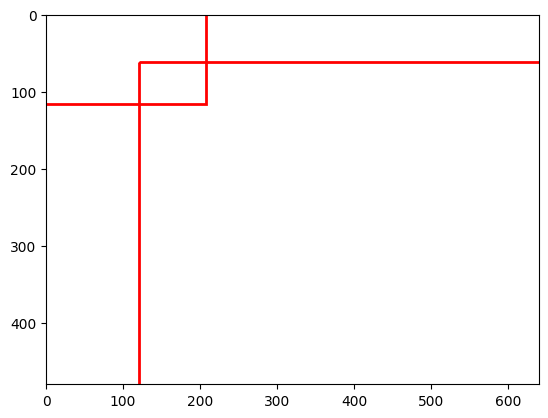

In [ ]:
# --- Visualization ---

def show_boxes(preds, targets, img_w=640, img_h=480):
    fig, ax = plt.subplots()
    preds = preds.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()
    for (x, y, w, h) in preds:
        ax.add_patch(patches.Rectangle(
            ((x - w/2) * img_w, (y - h/2) * img_h),
            w * img_w, h * img_h, edgecolor='r', facecolor='none', linewidth=2))
    for (x, y, w, h) in targets:
        ax.add_patch(patches.Rectangle(
            ((x - w/2) * img_w, (y - h/2) * img_h),
            w * img_w, h * img_h, edgecolor='g', facecolor='none', linewidth=2))
    ax.set_xlim(0, img_w)
    ax.set_ylim(img_h, 0)
    ax.set_aspect('equal')
    plt.show()

# --- Example prediction visualization ---

X, Y = val_pairs[291]
X_enc = encode_objects(X).to(device)
pred_boxes, pred_conf = model(X_enc)
conf_thresh = 0.1
nms_thresh = 0.4
keep = pred_conf > conf_thresh
pred_boxes = pred_boxes[keep]
scores = pred_conf[keep]

pred_boxes_xyxy = boxes_cxcywh_to_xyxy(pred_boxes)
keep_indices = ops.nms(pred_boxes_xyxy, scores, nms_thresh)
pred_boxes = pred_boxes[keep_indices]

target_boxes = Y[Y[:,0] == 11][:, 1:].to(device)
show_boxes(pred_boxes, target_boxes)

Other methods of predictions below. Not really working so pivioted back to above methods.

In [ ]:
import os
import torch
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset

# === Directory setup ===
base_dir = "/content/drive/My Drive/SmartSpace/homeobjects-3K/labels"

train_input_dir = f"{base_dir}/train_input"
train_input_aug_dir = f"{base_dir}/train_input_aug"
val_input_dir = f"{base_dir}/val_input"
val_input_aug_dir = f"{base_dir}/val_input_aug"

train_target_dir = f"{base_dir}/train"
val_target_dir = f"{base_dir}/val"


# === Utility: Load YOLO labels ===
def load_labels(path):
    """Load bounding boxes from a YOLO-format label file."""
    boxes = []
    with open(path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                if len(parts) > 0:
                    print(f"⚠️ Skipped bad line in {path}: {parts}")
                continue
            cls, xc, yc, w, h = map(float, parts)
            boxes.append([int(cls), xc, yc, w, h])
    return (
        torch.tensor(boxes, dtype=torch.float32)
        if boxes
        else torch.zeros((0, 5), dtype=torch.float32)
    )


# === Encode bounding boxes (excluding frames) ===
def encode_objects(boxes, num_classes=12):
    """
    Encode bounding boxes as one-hot + spatial features.
    Excludes picture frames (class 11).
    """
    feats = []
    num_obj_classes = num_classes - 1  # excluding class 11

    for b in boxes:
        cls, xc, yc, w, h = b
        if int(cls) == 11:
            continue  # skip frames
        onehot = F.one_hot(torch.tensor(int(cls)), num_classes=num_obj_classes)
        feats.append(torch.cat([onehot.float(), torch.tensor([xc, yc, w, h])]))

    # Fallback if no non-frame objects
    return torch.stack(feats) if feats else torch.zeros((1, num_obj_classes + 4))


# === Dataset class for lazy loading ===
class FramePlacementDataset(Dataset):
    def __init__(self, input_dir, target_dir):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.files = [f for f in os.listdir(input_dir) if f.endswith(".txt")]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        target_fname = fname.replace("_aug.txt", ".txt")
        input_path = os.path.join(self.input_dir, fname)
        target_path = os.path.join(self.target_dir, target_fname)

        X = load_labels(input_path)   # scene without (some) frames
        Y = load_labels(target_path)  # full scene with all frames

        return X, Y


# === Combine normal + augmented datasets (lazy loading) ===
train_dataset = ConcatDataset([
    FramePlacementDataset(train_input_dir, train_target_dir),
    FramePlacementDataset(train_input_aug_dir, train_target_dir)
])

val_dataset = ConcatDataset([
    FramePlacementDataset(val_input_dir, val_target_dir),
    FramePlacementDataset(val_input_aug_dir, val_target_dir)
])

# === Dataloaders ===
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)

print(f"✅ Dataloaders ready: {len(train_dataset)} train samples, {len(val_dataset)} val samples.")


✅ Dataloaders ready: 2601 train samples, 477 val samples.


In [ ]:
for i, (X, Y) in enumerate(train_loader):
    print(f"Batch {i}: X shape={X.shape}, Y shape={Y.shape}")
    if i == 2: break

Batch 0: X shape=torch.Size([1, 9, 5]), Y shape=torch.Size([1, 9, 5])
Batch 1: X shape=torch.Size([1, 6, 5]), Y shape=torch.Size([1, 8, 5])
Batch 2: X shape=torch.Size([1, 5, 5]), Y shape=torch.Size([1, 5, 5])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from scipy.optimize import linear_sum_assignment

# === DETR-style Transformer for Painting Placement ===
class DETRPainting(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_layers=2, num_queries=10):
        super().__init__()
        self.num_queries = num_queries

        # Encode object features
        self.input_proj = nn.Linear(input_dim, d_model)

        # Learnable slot queries
        self.query_embed = nn.Parameter(torch.randn(num_queries, d_model))

        # Transformer
        self.transformer = nn.Transformer(
            d_model=d_model, nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            batch_first=True
        )

        # Predict presence and bbox
        self.pred_class = nn.Linear(d_model, 1)  # presence probability
        self.pred_bbox = nn.Linear(d_model, 4)

    def forward(self, x):
        batch_size = x.size(0)
        enc = self.input_proj(x)  # [B, N, d_model]
        queries = self.query_embed.unsqueeze(0).expand(batch_size, -1, -1)  # [B, Q, d_model]
        out = self.transformer(enc, queries)
        pred_class = torch.sigmoid(self.pred_class(out)).squeeze(-1)
        pred_bbox = torch.sigmoid(self.pred_bbox(out))
        return pred_class, pred_bbox


# === Hungarian Matching ===
def hungarian_match(pred_boxes, target_boxes, pred_class, target_presence):
    """
    pred_boxes: [Q,4], pred_class: [Q]
    target_boxes: [T,4], target_presence: [T]
    Returns matched indices (pred_idx, target_idx)
    """
    if target_boxes.numel() == 0:
        return torch.tensor([], dtype=torch.long), torch.tensor([], dtype=torch.long)

    # Compute cost matrix: L1 + 1-IoU
    cost_bbox = torch.cdist(pred_boxes, target_boxes, p=1)
    iou_matrix = torchvision.ops.box_iou(xywh_to_xyxy(pred_boxes), xywh_to_xyxy(target_boxes))
    cost_iou = 1 - iou_matrix
    # Combine costs
    cost_matrix = cost_bbox + cost_iou
    # Solve Hungarian
    pred_idx, tgt_idx = linear_sum_assignment(cost_matrix.detach().cpu())
    return torch.tensor(pred_idx, dtype=torch.long), torch.tensor(tgt_idx, dtype=torch.long)


# === Loss ===
def detr_painting_loss(pred_class, pred_boxes, target_boxes, target_presence):
    """
    pred_class: [B,Q], pred_boxes: [B,Q,4]
    target_boxes: list of tensors [Ti,4], target_presence: list of tensors [Ti]
    """
    batch_size, Q, _ = pred_boxes.shape
    total_loss = 0.0
    for b in range(batch_size):
        pb = pred_boxes[b]
        pc = pred_class[b]
        tb = target_boxes[b]
        tp = target_presence[b]
        pred_idx, tgt_idx = hungarian_match(pb, tb, pc, tp)

        if len(pred_idx) > 0:
            # Classification loss for matched slots
            cls_loss = F.binary_cross_entropy(pc[pred_idx], tp[tgt_idx])
            # Box loss: L1 + GIoU
            bbox_l1 = F.l1_loss(pb[pred_idx], tb[tgt_idx])
            bbox_giou = 1 - torch.diag(torchvision.ops.generalized_box_iou(
                xywh_to_xyxy(pb[pred_idx]),
                xywh_to_xyxy(tb[tgt_idx])
            )).mean()
            total_loss += cls_loss + bbox_l1 + bbox_giou
        else:
            total_loss += pc.mean()  # penalize false positives

    return total_loss / batch_size


# === Helper xywh -> xyxy ===
def xywh_to_xyxy(boxes):
    x, y, w, h = boxes.unbind(-1)
    return torch.stack([x - w/2, y - h/2, x + w/2, y + h/2], dim=-1)


In [ ]:
#model v3

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from tqdm import tqdm

# === Directories ===
base_dir = "/content/drive/My Drive/SmartSpace/homeobjects-3K/labels"

train_input_dir = f"{base_dir}/train_input"
train_input_aug_dir = f"{base_dir}/train_input_aug"
val_input_dir = f"{base_dir}/val_input"
val_input_aug_dir = f"{base_dir}/val_input_aug"

train_target_dir = f"{base_dir}/train"
val_target_dir = f"{base_dir}/val"

# === Load YOLO labels ===
def load_labels(path):
    boxes = []
    if not os.path.exists(path):
        return torch.zeros((0,5), dtype=torch.float32)
    with open(path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls, xc, yc, w, h = map(float, parts)
            boxes.append([int(cls), xc, yc, w, h])
    return torch.tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0,5), dtype=torch.float32)

# === Dataset ===
class FramePlacementDataset(Dataset):
    def __init__(self, input_dir, target_dir):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.files = [f for f in os.listdir(input_dir) if f.endswith(".txt")]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        target_fname = fname.replace("_aug.txt", ".txt")
        X = load_labels(os.path.join(self.input_dir, fname))
        Y = load_labels(os.path.join(self.target_dir, target_fname))
        return X, Y

# === Encode objects (skipping frames) ===
def encode_objects(boxes, num_classes=12):
    feats = []
    num_obj_classes = num_classes - 1
    for b in boxes:
        cls, xc, yc, w, h = b
        if int(cls) == 11:  # skip frame
            continue
        onehot = F.one_hot(torch.tensor(int(cls)), num_classes=num_obj_classes)
        feats.append(torch.cat([onehot.float(), torch.tensor([xc, yc, w, h])]))
    if feats:
        return torch.stack(feats)
    else:
        return None  # <-- return None for zero objects

# === IoU Loss ===
def iou_loss(pred_boxes, target_boxes, eps=1e-6):
    pred_xy1 = pred_boxes[..., :2] - pred_boxes[..., 2:] / 2
    pred_xy2 = pred_boxes[..., :2] + pred_boxes[..., 2:] / 2
    target_xy1 = target_boxes[..., :2] - target_boxes[..., 2:] / 2
    target_xy2 = target_boxes[..., :2] + target_boxes[..., 2:] / 2

    inter_xy1 = torch.max(pred_xy1, target_xy1)
    inter_xy2 = torch.min(pred_xy2, target_xy2)
    inter_wh = (inter_xy2 - inter_xy1).clamp(min=0)
    inter_area = inter_wh[..., 0] * inter_wh[..., 1]

    pred_area = pred_boxes[..., 2] * pred_boxes[..., 3]
    target_area = target_boxes[..., 2] * target_boxes[..., 3]

    union_area = pred_area + target_area - inter_area + eps
    iou = inter_area / union_area
    return 1 - iou.mean()

# === Transformer model ===
class PaintingsTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, num_classes=12):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, 5)  # [cls_prob, xc, yc, w, h]

    def forward(self, x):
        x = self.input_proj(x)
        x = self.encoder(x)  # batch_first=True
        out = self.decoder(x)
        return out

# === Training loop ===
def train_val_loop(model, train_loader, val_loader, epochs, lr, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    criterion = iou_loss  # or nn.MSELoss() for initial testing

    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        train_loss = 0
        for X, Y in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
            optimizer.zero_grad()
            batch_loss = 0
            for xi, yi in zip(X, Y):
                xi_enc = encode_objects(xi)
                yi_enc = encode_objects(yi)
                if xi_enc is None or yi_enc is None:
                    continue  # skip zero-object scenes
                xi_enc = xi_enc.unsqueeze(0).to(device)
                yi_enc = yi_enc.to(device)
                pred = model(xi_enc).squeeze(0)
                batch_loss += criterion(pred[:, -4:], yi_enc[:, -4:])
            if batch_loss > 0:
                batch_loss.backward()
                optimizer.step()
                train_loss += batch_loss.item()
        train_loss /= len(train_loader)

        # ---- Validation ----
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, Y in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
                batch_loss = 0
                for xi, yi in zip(X, Y):
                    xi_enc = encode_objects(xi)
                    yi_enc = encode_objects(yi)
                    if xi_enc is None or yi_enc is None:
                        continue
                    xi_enc = xi_enc.unsqueeze(0).to(device)
                    yi_enc = yi_enc.to(device)
                    pred = model(xi_enc).squeeze(0)
                    batch_loss += criterion(pred[:, -4:], yi_enc[:, -4:])
                if batch_loss > 0:
                    val_loss += batch_loss.item()
        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}/{epochs}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")
    return val_loss

# === Data Loaders ===
train_dataset = ConcatDataset([
    FramePlacementDataset(train_input_dir, train_target_dir),
    FramePlacementDataset(train_input_aug_dir, train_target_dir)
])
val_dataset = ConcatDataset([
    FramePlacementDataset(val_input_dir, val_target_dir),
    FramePlacementDataset(val_input_aug_dir, val_target_dir)
])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# === Model & training ===
device = "cuda" if torch.cuda.is_available() else "cpu"
model = PaintingsTransformer(input_dim=15, d_model=32, nhead=1, num_layers=1).to(device)

train_val_loop(model, train_loader, val_loader, epochs=2, lr=1e-3, device=device)


Epoch 1 [Val]: 100%|██████████| 477/477 [06:05<00:00,  1.30it/s]


Epoch 1/2: train_loss=0.7348, val_loss=0.6102


Epoch 2 [Val]: 100%|██████████| 477/477 [00:06<00:00, 74.88it/s]

Epoch 2/2: train_loss=0.5869, val_loss=0.5214


0.5214375742326492

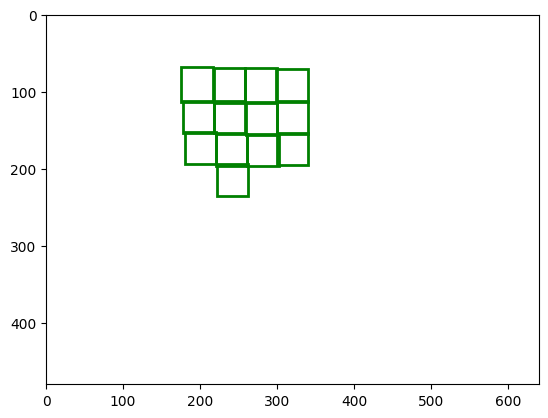

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_boxes(preds, targets, img_w=640, img_h=480):
    fig, ax = plt.subplots()

    preds = preds.detach().cpu()
    targets = targets.detach().cpu()

    # preds assumed to be [num_objs, 5]: [cls_logit, xc, yc, w, h]
    # Convert class logits to class IDs
    if preds.shape[1] > 4:
        cls_pred = preds[:, 0].argmax(dim=-1)  # if logits for multiple classes
        preds = preds[cls_pred==11][:, 1:]    # only class 11
    # Else, preds already bbox-only

    # Draw predictions
    for (x, y, w, h) in preds:
        ax.add_patch(patches.Rectangle(
            ((x - w/2) * img_w, (y - h/2) * img_h),
            w * img_w, h * img_h, edgecolor='r', facecolor='none', linewidth=2
        ))

    # Draw targets
    for (x, y, w, h) in targets:
        ax.add_patch(patches.Rectangle(
            ((x - w/2) * img_w, (y - h/2) * img_h),
            w * img_w, h * img_h, edgecolor='g', facecolor='none', linewidth=2
        ))

    ax.set_xlim(0, img_w)
    ax.set_ylim(img_h, 0)
    ax.set_aspect('equal')
    plt.show()
X, Y = val_dataset[100]  # or any sample
X_enc = encode_objects(X)  # this skips class 11
preds = model(X_enc.unsqueeze(0).to(device)).squeeze(0)  # [num_objs, 5]

# Targets: only class 11
targets = Y[Y[:,0]==11][:,1:]  # [xc,yc,w,h]

show_boxes(preds, targets)


In [ ]:
#v4

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment

# === Directories ===
base_dir = "/content/drive/My Drive/SmartSpace/homeobjects-3K/labels"

train_input_dir = f"{base_dir}/train_input"
train_input_aug_dir = f"{base_dir}/train_input_aug"
val_input_dir = f"{base_dir}/val_input"
val_input_aug_dir = f"{base_dir}/val_input_aug"

train_target_dir = f"{base_dir}/train"
val_target_dir = f"{base_dir}/val"

# === Load YOLO labels ===
def load_labels(path):
    boxes = []
    if not os.path.exists(path):
        return torch.zeros((0,5), dtype=torch.float32)
    with open(path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls, xc, yc, w, h = map(float, parts)
            boxes.append([int(cls), xc, yc, w, h])
    return torch.tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0,5), dtype=torch.float32)

# === Dataset ===
class FramePlacementDataset(Dataset):
    def __init__(self, input_dir, target_dir):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.files = [f for f in os.listdir(input_dir) if f.endswith(".txt")]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        target_fname = fname.replace("_aug.txt", ".txt")
        X = load_labels(os.path.join(self.input_dir, fname))
        Y = load_labels(os.path.join(self.target_dir, target_fname))
        return X, Y

# === Encode all objects ===
def encode_objects(boxes, num_classes=12):
    feats = []
    for b in boxes:
        cls, xc, yc, w, h = b
        onehot = F.one_hot(torch.tensor(int(cls)), num_classes=num_classes)
        feats.append(torch.cat([onehot.float(), torch.tensor([xc, yc, w, h])]))
    if feats:
        return torch.stack(feats)
    else:
        return None

# === IoU loss for box regression ===
def iou_loss(pred_boxes, target_boxes, eps=1e-6):
    pred_xy1 = pred_boxes[..., :2] - pred_boxes[..., 2:] / 2
    pred_xy2 = pred_boxes[..., :2] + pred_boxes[..., 2:] / 2
    target_xy1 = target_boxes[..., :2] - target_boxes[..., 2:] / 2
    target_xy2 = target_boxes[..., :2] + target_boxes[..., 2:] / 2

    inter_xy1 = torch.max(pred_xy1, target_xy1)
    inter_xy2 = torch.min(pred_xy2, target_xy2)
    inter_wh = (inter_xy2 - inter_xy1).clamp(min=0)
    inter_area = inter_wh[...,0] * inter_wh[...,1]

    pred_area = pred_boxes[...,2] * pred_boxes[...,3]
    target_area = target_boxes[...,2] * target_boxes[...,3]

    union_area = pred_area + target_area - inter_area + eps
    iou = inter_area / union_area
    return 1 - iou.mean()

# === Transformer model ===
class PaintingsTransformer(nn.Module):
    def __init__(self, input_dim, d_model=32, nhead=1, num_layers=1, num_classes=12):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.cls_head = nn.Linear(d_model, num_classes)   # class logits
        self.box_head = nn.Linear(d_model, 4)            # bbox regression

    def forward(self, x):
        x = self.input_proj(x)
        x = self.encoder(x)
        cls_logits = self.cls_head(x)
        bbox_pred = self.box_head(x)
        return cls_logits, bbox_pred

# === Hungarian matching loss ===
def hungarian_loss(pred_cls_logits, pred_boxes, target_boxes, conf_thresh=0.2):
    cls_probs = F.softmax(pred_cls_logits, dim=-1)
    pred_mask = cls_probs.max(dim=-1).values > conf_thresh
    filtered_pred_boxes = pred_boxes[pred_mask]

    if target_boxes.shape[0]==0 or filtered_pred_boxes.shape[0]==0:
        return torch.tensor(0., device=pred_boxes.device)

    cost_matrix = torch.zeros(filtered_pred_boxes.shape[0], target_boxes.shape[0], device=pred_boxes.device)
    for i, p in enumerate(filtered_pred_boxes):
        for j, t in enumerate(target_boxes):
            cost_matrix[i,j] = iou_loss(p.unsqueeze(0), t.unsqueeze(0))

    row_ind, col_ind = linear_sum_assignment(cost_matrix.detach().cpu())
    matched_pred = filtered_pred_boxes[row_ind]
    matched_target = target_boxes[col_ind].to(filtered_pred_boxes.device)
    return iou_loss(matched_pred, matched_target)

# === Training loop ===
def train_val_loop(model, train_loader, val_loader, epochs, lr, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        train_loss = 0
        for X, Y in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
            optimizer.zero_grad()
            batch_loss = 0
            for xi, yi in zip(X, Y):
                xi_enc = encode_objects(xi)
                if xi_enc is None:
                    continue
                xi_enc = xi_enc.unsqueeze(0).to(device)
                yi_boxes = yi[:,1:].to(device)  # use all targets
                cls_logits, bbox_pred = model(xi_enc)
                cls_logits = cls_logits.squeeze(0)
                bbox_pred = bbox_pred.squeeze(0)
                batch_loss += hungarian_loss(cls_logits, bbox_pred, yi_boxes)
            if batch_loss > 0:
                batch_loss.backward()
                optimizer.step()
                train_loss += batch_loss.item()
        train_loss /= len(train_loader)

        # ---- Validation ----
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, Y in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
                batch_loss = 0
                for xi, yi in zip(X, Y):
                    xi_enc = encode_objects(xi)
                    if xi_enc is None:
                        continue
                    xi_enc = xi_enc.unsqueeze(0).to(device)
                    yi_boxes = yi[:,1:].to(device)
                    cls_logits, bbox_pred = model(xi_enc)
                    cls_logits = cls_logits.squeeze(0)
                    bbox_pred = bbox_pred.squeeze(0)
                    batch_loss += hungarian_loss(cls_logits, bbox_pred, yi_boxes)
                val_loss += batch_loss.item() if batch_loss>0 else 0
        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1}/{epochs}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")

# === Visualization ===
def show_boxes(cls_logits, bbox_pred, targets, img_w=640, img_h=480, conf_thresh=0.5):
    cls_probs = F.softmax(cls_logits, dim=-1)
    pred_mask = cls_probs.max(dim=-1).values > conf_thresh
    pred_boxes = bbox_pred[pred_mask].detach().cpu()
    targets = targets.detach().cpu()

    fig, ax = plt.subplots()
    for (x, y, w, h) in pred_boxes:
        ax.add_patch(patches.Rectangle(
            ((x - w/2) * img_w, (y - h/2) * img_h),
            w * img_w, h * img_h, edgecolor='r', facecolor='none', linewidth=2
        ))
    for (x, y, w, h) in targets[:,1:]:
        ax.add_patch(patches.Rectangle(
            ((x - w/2) * img_w, (y - h/2) * img_h),
            w * img_w, h * img_h, edgecolor='g', facecolor='none', linewidth=2
        ))
    ax.set_xlim(0, img_w)
    ax.set_ylim(img_h, 0)
    ax.set_aspect('equal')
    plt.show()

# === Data Loaders ===
train_dataset = ConcatDataset([
    FramePlacementDataset(train_input_dir, train_target_dir),
    FramePlacementDataset(train_input_aug_dir, train_target_dir)
])
val_dataset = ConcatDataset([
    FramePlacementDataset(val_input_dir, val_target_dir),
    FramePlacementDataset(val_input_aug_dir, val_target_dir)
])
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# === Model & training ===
device = "cuda" if torch.cuda.is_available() else "cpu"
model = PaintingsTransformer(input_dim=16, d_model=32, nhead=1, num_layers=1).to(device)

# === Train ===
train_val_loop(model, train_loader, val_loader, epochs=2, lr=1e-3, device=device)


Epoch 1 [Val]: 100%|██████████| 477/477 [00:06<00:00, 72.09it/s]


Epoch 1/2: train_loss=0.6636, val_loss=0.0000


Epoch 2 [Val]: 100%|██████████| 477/477 [00:06<00:00, 73.95it/s]

Epoch 2/2: train_loss=0.7074, val_loss=0.0000


In [ ]:
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
from torch.optim.lr_scheduler import ReduceLROnPlateau, LambdaLR
from torch.cuda.amp import autocast, GradScaler
from contextlib import nullcontext


# === Dataset and label loading === (unchanged from before)
def load_labels(path):
    boxes = []
    if not os.path.exists(path):
        return torch.zeros((0,5), dtype=torch.float32)
    with open(path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls, xc, yc, w, h = map(float, parts)
            boxes.append([int(cls), xc, yc, w, h])
    return torch.tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0,5), dtype=torch.float32)

class FramePlacementDataset(Dataset):
    def __init__(self, input_dir, target_dir):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.files = [f for f in os.listdir(input_dir) if f.endswith(".txt")]
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        fname = self.files[idx]
        target_fname = fname.replace("_aug.txt", ".txt")
        X = load_labels(os.path.join(self.input_dir, fname))
        Y = load_labels(os.path.join(self.target_dir, target_fname))
        return X, Y

def encode_input_objects(boxes, num_classes=12):
    feats = []
    for b in boxes:
        cls, xc, yc, w, h = b
        onehot = F.one_hot(torch.tensor(int(cls)), num_classes=num_classes)
        feats.append(torch.cat([onehot.float(), torch.tensor([xc, yc, w, h])]))
    if feats:
        return torch.stack(feats)
    else:
        return None

def encode_target_class11(boxes):
    class11_boxes = boxes[boxes[:, 0] == 11][:, 1:]
    if class11_boxes.shape[0] == 0:
        return None
    return class11_boxes.float()


# === Loss functions and model === (unchanged from before)
def iou_loss(pred_boxes, target_boxes, eps=1e-6):
    pred_xy1 = pred_boxes[:, :2] - pred_boxes[:, 2:] / 2
    pred_xy2 = pred_boxes[:, :2] + pred_boxes[:, 2:] / 2
    target_xy1 = target_boxes[:, :2] - target_boxes[:, 2:] / 2
    target_xy2 = target_boxes[:, :2] + target_boxes[:, 2:] / 2

    inter_min = torch.max(pred_xy1, target_xy1)
    inter_max = torch.min(pred_xy2, target_xy2)
    inter_wh = (inter_max - inter_min).clamp(min=0)
    inter_area = inter_wh[:, 0] * inter_wh[:, 1]

    pred_area = pred_boxes[:, 2] * pred_boxes[:, 3]
    target_area = target_boxes[:, 2] * target_boxes[:, 3]

    union_area = pred_area + target_area - inter_area + eps
    iou = inter_area / union_area
    return 1 - iou.mean()

def combined_hungarian_loss(pred_boxes, target_boxes, l1_weight=10.0):
    if target_boxes is None or pred_boxes.shape[0] == 0:
        return torch.tensor(0., device=pred_boxes.device, requires_grad=True)
    cost_matrix = torch.zeros(pred_boxes.shape[0], target_boxes.shape[0], device=pred_boxes.device)
    for i, p in enumerate(pred_boxes):
        for j, t in enumerate(target_boxes):
            iou_comp = 1 - (1 - iou_loss(p.unsqueeze(0), t.unsqueeze(0)))  # IoU itself
            l1_comp = F.l1_loss(p, t, reduction='mean')
            cost_matrix[i, j] = (1 - iou_comp) + l1_weight * l1_comp
    row_ind, col_ind = linear_sum_assignment(cost_matrix.detach().cpu().numpy())
    matched_pred = pred_boxes[row_ind]
    matched_target = target_boxes[col_ind].to(pred_boxes.device)
    return iou_loss(matched_pred, matched_target) + l1_weight * F.l1_loss(matched_pred, matched_target)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

class PaintingsTransformer(nn.Module):
    def __init__(self, input_dim=16, d_model=64, nhead=4, num_layers=4, dropout=0.2, max_len=100):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.box_head = nn.Linear(d_model, 4)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_enc(x)
        x = self.encoder(x)
        bbox_pred = self.box_head(x)
        return bbox_pred

# === Metrics calculation functions ===
def box_iou(box1, box2, eps=1e-7):
    box1_xy1 = box1[:, :2] - box1[:, 2:] / 2
    box1_xy2 = box1[:, :2] + box1[:, 2:] / 2
    box2_xy1 = box2[:, :2] - box2[:, 2:] / 2
    box2_xy2 = box2[:, :2] + box2[:, 2:] / 2

    inter_xy1 = torch.max(box1_xy1[:, None, :], box2_xy1[None, :, :])
    inter_xy2 = torch.min(box1_xy2[:, None, :], box2_xy2[None, :, :])
    inter_wh = (inter_xy2 - inter_xy1).clamp(min=0)
    inter_area = inter_wh[:, :, 0] * inter_wh[:, :, 1]

    box1_area = box1[:, 2] * box1[:, 3]
    box2_area = box2[:, 2] * box2[:, 3]

    union_area = box1_area[:, None] + box2_area[None, :] - inter_area + eps
    iou = inter_area / union_area
    return iou

def precision_recall_f1(pred_boxes, target_boxes, iou_thresh=0.5):
    if pred_boxes is None or target_boxes is None or (pred_boxes.shape[0] == 0 and target_boxes.shape[0] == 0):
        return 1.0, 1.0, 1.0
    elif pred_boxes is None or pred_boxes.shape[0] == 0:
        return 0.0, 0.0, 0.0
    elif target_boxes is None or target_boxes.shape[0] == 0:
        return 0.0, 1.0, 0.0

    ious = box_iou(pred_boxes, target_boxes)  # (num_pred, num_target)
    matches = ious > iou_thresh

    true_positives = matches.any(dim=1).sum().item()
    false_positives = (matches.any(dim=1) == 0).sum().item()
    false_negatives = (matches.any(dim=0) == 0).sum().item()

    precision = true_positives / (true_positives + false_positives + 1e-7)
    recall = true_positives / (true_positives + false_negatives + 1e-7)
    f1 = 2 * precision * recall / (precision + recall + 1e-7)
    return precision, recall, f1


# === LR Warmup scheduler helper ===
def get_warmup_scheduler(optimizer, warmup_steps):
    def lr_lambda(current_step):
        if current_step >= warmup_steps:
            return 1.0
        else:
            return float(current_step) / float(max(1, warmup_steps))
    return LambdaLR(optimizer, lr_lambda=lr_lambda)


# === Training + validation with metrics and early stopping ===
def train_val_loop(model, train_loader, val_loader, epochs, lr, warmup_steps, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    warmup_scheduler = get_warmup_scheduler(optimizer, warmup_steps)
    plateau_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    model.to(device)

    scaler = GradScaler() if torch.cuda.is_available() else None
    autocast_context = autocast if torch.cuda.is_available() else nullcontext

    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    patience = 3
    trigger_times = 0
    global_step = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X, Y in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
            optimizer.zero_grad()
            batch_loss = 0
            for xi, yi in zip(X, Y):
                xi_enc = encode_input_objects(xi)
                if xi_enc is None:
                    continue
                xi_enc = xi_enc.unsqueeze(0).to(device)
                yi_enc = encode_target_class11(yi)
                if yi_enc is None:
                    continue
                yi_enc = yi_enc.to(device)
                with autocast_context():
                    bbox_pred = model(xi_enc).squeeze(0)
                    loss = combined_hungarian_loss(bbox_pred, yi_enc)
                if loss > 0:
                    if scaler is not None:
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()
                    else:
                        loss.backward()
                        optimizer.step()
                    batch_loss += loss.item()
                else:
                    batch_loss += loss.item()
                if global_step < warmup_steps:
                    warmup_scheduler.step()
                global_step += 1
            train_loss += batch_loss
        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0
        all_precisions, all_recalls, all_f1s = [], [], []
        with torch.no_grad():
            for X, Y in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
                batch_loss = 0
                for xi, yi in zip(X, Y):
                    xi_enc = encode_input_objects(xi)
                    if xi_enc is None:
                        continue
                    xi_enc = xi_enc.unsqueeze(0).to(device)
                    yi_enc = encode_target_class11(yi)
                    if yi_enc is None:
                        continue
                    yi_enc = yi_enc.to(device)
                    with autocast_context():
                        bbox_pred = model(xi_enc).squeeze(0)
                        loss = combined_hungarian_loss(bbox_pred, yi_enc)
                    batch_loss += loss.item()

                    # Calculate metrics (clamp boxes to [0,1] for IoU)
                    pred_boxes = bbox_pred.clamp(0, 1).cpu()
                    target_boxes = yi_enc.cpu()
                    prec, rec, f1 = precision_recall_f1(pred_boxes, target_boxes)
                    all_precisions.append(prec)
                    all_recalls.append(rec)
                    all_f1s.append(f1)
                val_loss += batch_loss
        val_loss /= len(val_loader)

        mean_prec = sum(all_precisions) / len(all_precisions) if all_precisions else 0
        mean_rec = sum(all_recalls) / len(all_recalls) if all_recalls else 0
        mean_f1 = sum(all_f1s) / len(all_f1s) if all_f1s else 0

        print(f"Epoch {epoch+1}/{epochs}: train_loss={train_loss:.6f}, val_loss={val_loss:.6f}, "
              f"val_Precision={mean_prec:.4f}, val_Recall={mean_rec:.4f}, val_F1={mean_f1:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # LR scheduler step after warmup
        if global_step >= warmup_steps:
            plateau_scheduler.step(val_loss)

    # Load best model weights after training completes/early stopping
    model.load_state_dict(best_model_wts)

# === DataLoader setup ===
base_dir = "/content/drive/My Drive/SmartSpace/homeobjects-3K/labels"
train_input_dir = f"{base_dir}/train_input"
train_input_aug_dir = f"{base_dir}/train_input_aug"
val_input_dir = f"{base_dir}/val_input"
val_input_aug_dir = f"{base_dir}/val_input_aug"
train_target_dir = f"{base_dir}/train"
val_target_dir = f"{base_dir}/val"

num_workers = 2
pin_memory = torch.cuda.is_available()

train_dataset = ConcatDataset([
    FramePlacementDataset(train_input_dir, train_target_dir),
    FramePlacementDataset(train_input_aug_dir, train_target_dir)
])
val_dataset = ConcatDataset([
    FramePlacementDataset(val_input_dir, val_target_dir),
    FramePlacementDataset(val_input_aug_dir, val_target_dir)
])
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = PaintingsTransformer(input_dim=16, d_model=64, nhead=4, num_layers=4, dropout=0.2).to(device)

warmup_steps = 1000

# Start training
train_val_loop(model, train_loader, val_loader, epochs=10, lr=1e-3, warmup_steps=warmup_steps, device=device)


Epoch 1 [Val]: 100%|██████████| 477/477 [00:10<00:00, 45.51it/s]


Epoch 1/10: train_loss=1.166032, val_loss=1.409517, val_Precision=0.0064, val_Recall=0.0068, val_F1=0.0064


Epoch 2 [Val]: 100%|██████████| 477/477 [00:10<00:00, 43.89it/s]


Epoch 2/10: train_loss=1.024541, val_loss=1.256212, val_Precision=0.0106, val_Recall=0.0070, val_F1=0.0084


Epoch 3 [Val]: 100%|██████████| 477/477 [00:10<00:00, 44.00it/s]


Epoch 3/10: train_loss=1.013722, val_loss=1.297500, val_Precision=0.0088, val_Recall=0.0077, val_F1=0.0073


Epoch 4 [Val]: 100%|██████████| 477/477 [00:10<00:00, 45.59it/s]


Epoch 4/10: train_loss=1.006586, val_loss=1.425765, val_Precision=0.0141, val_Recall=0.0103, val_F1=0.0119


Epoch 5 [Val]: 100%|██████████| 477/477 [00:09<00:00, 49.47it/s]

Epoch 5/10: train_loss=1.009543, val_loss=1.325693, val_Precision=0.0141, val_Recall=0.0115, val_F1=0.0125
Early stopping at epoch 5


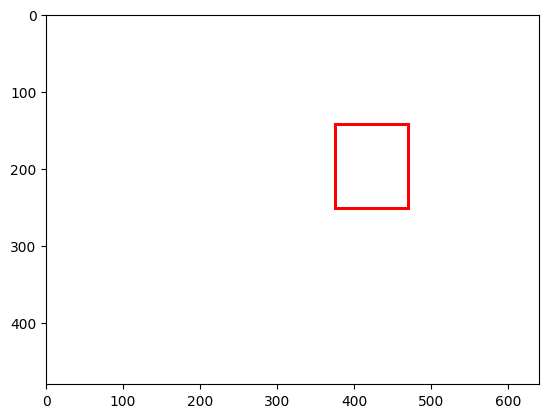

In [ ]:
def show_boxes(bbox_pred, targets, img_w=640, img_h=480):
    """
    bbox_pred: [num_pred, 4] - predicted boxes (xc, yc, w, h, normalized)
    targets: [num_target, 5] - target boxes (cls, xc, yc, w, h)
    """

    pred_boxes = bbox_pred.detach().cpu()
    target_boxes = targets[targets[:, 0] == 11][:, 1:].detach().cpu()

    fig, ax = plt.subplots()

    # Red = predicted boxes (all assumed class 11)
    for (x, y, w, h) in pred_boxes:
        ax.add_patch(patches.Rectangle(
            ((x - w/2) * img_w, (y - h/2) * img_h),
            w * img_w, h * img_h,
            edgecolor='r', facecolor='none', linewidth=2
        ))

    # Green = ground truth boxes class 11
    for (x, y, w, h) in target_boxes:
        ax.add_patch(patches.Rectangle(
            ((x - w/2) * img_w, (y - h/2) * img_h),
            w * img_w, h * img_h,
            edgecolor='g', facecolor='none', linewidth=2
        ))

    ax.set_xlim(0, img_w)
    ax.set_ylim(img_h, 0)
    ax.set_aspect('equal')
    plt.show()

# Example usage:
X, Y = val_dataset[14]
X_enc = encode_input_objects(X)
if X_enc is not None:
    bbox_pred = model(X_enc.unsqueeze(0).to(device)).squeeze(0)
    show_boxes(bbox_pred, Y, img_w=640, img_h=480)


In [ ]:
def show_boxes(cls_logits, bbox_pred, targets, img_w=640, img_h=480, conf_thresh=0.1):
    """
    cls_logits: [num_pred, 12] - class logits
    bbox_pred: [num_pred, 4] - predicted boxes (xc, yc, w, h, normalized)
    targets: [num_target, 5] - target boxes (cls, xc, yc, w, h)
    """
    cls_probs = F.softmax(cls_logits, dim=-1)

    # Only keep predictions where class 11 probability > conf_thresh
    pred_mask = cls_probs[:, 11] > conf_thresh
    pred_boxes = bbox_pred[pred_mask].detach().cpu()

    # Keep only target boxes of class 11
    target_boxes = targets[targets[:,0] == 11][:, 1:].detach().cpu()

    fig, ax = plt.subplots()

    # Red = predictions
    for (x, y, w, h) in pred_boxes:
        ax.add_patch(patches.Rectangle(
            ((x - w/2) * img_w, (y - h/2) * img_h),
            w * img_w, h * img_h,
            edgecolor='r', facecolor='none', linewidth=2
        ))

    # Green = targets
    for (x, y, w, h) in target_boxes:
        ax.add_patch(patches.Rectangle(
            ((x - w/2) * img_w, (y - h/2) * img_h),
            w * img_w, h * img_h,
            edgecolor='g', facecolor='none', linewidth=2
        ))

    ax.set_xlim(0, img_w)
    ax.set_ylim(img_h, 0)
    ax.set_aspect('equal')
    plt.show()


In [ ]:
X, Y = val_dataset[20]
X_enc = encode_objects(X)
if X_enc is not None:
    cls_logits, bbox_pred = model(X_enc.unsqueeze(0).to(device))
    cls_logits = cls_logits.squeeze(0)
    bbox_pred = bbox_pred.squeeze(0)
    show_boxes(cls_logits, bbox_pred, Y, conf_thresh=0.1)


ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
#Fixed code with everything that was deleted restored (I hope)----------------------------------------------------------------------------------------------------

FIXED CODE HERE

In [ ]:
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset, WeightedRandomSampler
import itertools
import csv
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau, LambdaLR
from torch.cuda.amp import autocast, GradScaler
from contextlib import nullcontext
import matplotlib.patches as patches
from scipy.optimize import linear_sum_assignment

# === Dataset and label loading ===

def load_labels(path):
    boxes = []
    if not os.path.exists(path):
        return torch.zeros((0,5), dtype=torch.float32)
    with open(path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls, xc, yc, w, h = map(float, parts)
            boxes.append([int(cls), xc, yc, w, h])
    return torch.tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0,5), dtype=torch.float32)

class FramePlacementDataset(Dataset):
    def __init__(self, input_dir, target_dir):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.files = [f for f in os.listdir(input_dir) if f.endswith(".txt")]
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        fname = self.files[idx]
        target_fname = fname.replace("_aug.txt", ".txt")
        X = load_labels(os.path.join(self.input_dir, fname))
        Y = load_labels(os.path.join(self.target_dir, target_fname))
        return X, Y

def encode_input_objects(boxes, num_classes=12):
    feats = []
    for b in boxes:
        cls, xc, yc, w, h = b
        onehot = F.one_hot(torch.tensor(int(cls)), num_classes=num_classes)
        feats.append(torch.cat([onehot.float(), torch.tensor([xc, yc, w, h])]))
    if feats:
        return torch.stack(feats)
    else:
        return None

def encode_target_class11(boxes):
    class11_boxes = boxes[boxes[:, 0] == 11][:, 1:]
    if class11_boxes.shape[0] == 0:
        return None
    return class11_boxes.float()

# === Loss functions ===

def iou_loss(pred_boxes, target_boxes, eps=1e-6):
    pred_xy1 = pred_boxes[:, :2] - pred_boxes[:, 2:] / 2
    pred_xy2 = pred_boxes[:, :2] + pred_boxes[:, 2:] / 2
    target_xy1 = target_boxes[:, :2] - target_boxes[:, 2:] / 2
    target_xy2 = target_boxes[:, :2] + target_boxes[:, 2:] / 2

    inter_min = torch.max(pred_xy1, target_xy1)
    inter_max = torch.min(pred_xy2, target_xy2)
    inter_wh = (inter_max - inter_min).clamp(min=0)
    inter_area = inter_wh[:, 0] * inter_wh[:, 1]

    pred_area = pred_boxes[:, 2] * pred_boxes[:, 3]
    target_area = target_boxes[:, 2] * target_boxes[:, 3]

    union_area = pred_area + target_area - inter_area + eps
    iou = inter_area / union_area
    return 1 - iou.mean()

def combined_hungarian_loss(pred_boxes, target_boxes, l1_weight=10.0):
    """
    pred_boxes: Tensor of shape (N_pred, 4)
    target_boxes: Tensor of shape (N_target, 4)

    Computes Hungarian matching loss combining IoU and L1 loss.
    This version vectorizes cost matrix computation using torch.cdist
    and performs optimal matching with scipy's linear_sum_assignment.
    """
    if target_boxes is None or pred_boxes.shape[0] == 0:
        return torch.tensor(0., device=pred_boxes.device, requires_grad=True)

    # Calculate L1 cost matrix (shape: N_pred x N_target)
    l1_cost = torch.cdist(pred_boxes, target_boxes, p=1)  # pairwise L1 distance

    # Calculate IoU cost matrix
    # For vectorized IoU, compute pairwise IoU between all pred and target boxes
    pred_xy1 = pred_boxes[:, :2] - pred_boxes[:, 2:] / 2
    pred_xy2 = pred_boxes[:, :2] + pred_boxes[:, 2:] / 2
    target_xy1 = target_boxes[:, :2] - target_boxes[:, 2:] / 2
    target_xy2 = target_boxes[:, :2] + target_boxes[:, 2:] / 2

    inter_min = torch.max(pred_xy1[:, None, :], target_xy1[None, :, :])
    inter_max = torch.min(pred_xy2[:, None, :], target_xy2[None, :, :])
    inter_wh = (inter_max - inter_min).clamp(min=0)  # shape (N_pred x N_target x 2)
    inter_area = inter_wh[..., 0] * inter_wh[..., 1]

    pred_area = (pred_boxes[:, 2] * pred_boxes[:, 3])[:, None]  # (N_pred, 1)
    target_area = (target_boxes[:, 2] * target_boxes[:, 3])[None, :]  # (1, N_target)

    union_area = pred_area + target_area - inter_area + 1e-6
    iou_cost = 1 - (inter_area / union_area)  # IoU cost matrix

    # Combine costs: IoU + weighted L1
    cost_matrix = iou_cost + l1_weight * l1_cost

    # Solve assignment using Hungarian algorithm (in numpy)
    cost_cpu = cost_matrix.detach().cpu().numpy()
    row_ind, col_ind = linear_sum_assignment(cost_cpu)

    matched_pred = pred_boxes[row_ind]
    matched_target = target_boxes[col_ind].to(pred_boxes.device)

    # Compute final loss: IoU loss + weighted L1 loss on matched pairs
    loss = (iou_cost[row_ind, col_ind]).mean() + l1_weight * F.l1_loss(matched_pred, matched_target)

    return loss

# === Positional Encoding ===

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

# === PaintingsTransformer Model ===

class PaintingsTransformer(nn.Module):
    def __init__(self, input_dim=16, d_model=64, nhead=4, num_layers=4, dropout=0.2, max_len=100):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.box_head = nn.Linear(d_model, 4)
    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_enc(x)
        x = self.encoder(x)
        bbox_pred = self.box_head(x)
        return bbox_pred

# === Training/validation loop (with warmup, early stop, mixed precision) ===

def get_warmup_scheduler(optimizer, warmup_steps):
    def lr_lambda(current_step):
        if current_step >= warmup_steps:
            return 1.0
        else:
            return float(current_step) / float(max(1, warmup_steps))
    return LambdaLR(optimizer, lr_lambda=lr_lambda)

def train_val_loop(model, train_loader, val_loader, epochs, lr, warmup_steps, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    warmup_scheduler = get_warmup_scheduler(optimizer, warmup_steps)
    plateau_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    model.to(device)

    scaler = GradScaler() if torch.cuda.is_available() else None
    autocast_context = autocast if torch.cuda.is_available() else nullcontext

    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    patience = 3
    trigger_times = 0
    global_step = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X, Y in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
            optimizer.zero_grad()
            batch_loss = 0
            for xi, yi in zip(X, Y):
                xi_enc = encode_input_objects(xi)
                if xi_enc is None:
                    continue
                xi_enc = xi_enc.unsqueeze(0).to(device)
                yi_enc = encode_target_class11(yi)
                if yi_enc is None:
                    continue
                yi_enc = yi_enc.to(device)
                with autocast_context():
                    bbox_pred = model(xi_enc).squeeze(0)
                    loss = combined_hungarian_loss(bbox_pred, yi_enc)
                if loss > 0:
                    if scaler is not None:
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()
                    else:
                        loss.backward()
                        optimizer.step()
                    batch_loss += loss.item()
                else:
                    batch_loss += loss.item()
                if global_step < warmup_steps:
                    warmup_scheduler.step()
                global_step += 1
            train_loss += batch_loss
        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, Y in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
                batch_loss = 0
                for xi, yi in zip(X, Y):
                    xi_enc = encode_input_objects(xi)
                    if xi_enc is None:
                        continue
                    xi_enc = xi_enc.unsqueeze(0).to(device)
                    yi_enc = encode_target_class11(yi)
                    if yi_enc is None:
                        continue
                    yi_enc = yi_enc.to(device)
                    with autocast_context():
                        bbox_pred = model(xi_enc).squeeze(0)
                        loss = combined_hungarian_loss(bbox_pred, yi_enc)
                    batch_loss += loss.item()
                val_loss += batch_loss
        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}/{epochs}: train_loss={train_loss:.6f}, val_loss={val_loss:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        if global_step >= warmup_steps:
            plateau_scheduler.step(val_loss)

    model.load_state_dict(best_model_wts)

# === Hyperparameter grid search ===

def collate_fn(batch):
    return tuple(zip(*batch))

def evaluate_val_loss(model, val_loader, device):
    model.eval()
    total_loss = 0
    count = 0
    with torch.no_grad():
        for X, Y in val_loader:
            for xi, yi in zip(X, Y):
                xi_enc = encode_input_objects(xi)
                if xi_enc is None:
                    continue
                xi_enc = xi_enc.unsqueeze(0).to(device)
                yi_enc = encode_target_class11(yi)
                if yi_enc is None:
                    continue
                yi_enc = yi_enc.to(device)
                bbox_pred = model(xi_enc).squeeze(0)
                loss = combined_hungarian_loss(bbox_pred, yi_enc)
                total_loss += loss.item()
                count += 1
    return total_loss / max(count,1)

def grid_search(param_grid, train_dataset, val_dataset, device, epochs=3, warmup_steps=100, log_csv_path="grid_search_log.csv"):
    keys = list(param_grid.keys())
    best_val_loss = float('inf')
    best_params = None
    best_model_wts = None

    def has_class_11(sample):
        X, Y = sample
        return (Y[:,0] == 11).any().item()

    sample_weights = []
    for i in range(len(train_dataset)):
        sample = train_dataset[i]
        sample_weights.append(5.0 if has_class_11(sample) else 1.0) # Oversample class 11 by 5x

    sample_weights = torch.DoubleTensor(sample_weights)
    train_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

    with open(log_csv_path, mode='w', newline='') as log_file:
        writer = csv.writer(log_file)
        writer.writerow(keys + ["val_loss"])

        for values in itertools.product(*param_grid.values()):
            params = dict(zip(keys, values))
            print(f"\nTesting params: {params}")

            train_loader = DataLoader(train_dataset,
                                      batch_size=params['batch_size'],
                                      sampler=train_sampler,
                                      num_workers=4,
                                      pin_memory=torch.cuda.is_available(),
                                      collate_fn=collate_fn)
            val_loader = DataLoader(val_dataset,
                                    batch_size=params['batch_size'],
                                    shuffle=False,
                                    num_workers=4,
                                    pin_memory=torch.cuda.is_available(),
                                    collate_fn=collate_fn)
            model = PaintingsTransformer(input_dim=16, d_model=params['d_model'],
                                         nhead=4, num_layers=params['num_layers'], dropout=0.2).to(device)
            train_val_loop(model, train_loader, val_loader, epochs=epochs, lr=params['lr'], warmup_steps=warmup_steps, device=device)
            val_loss = evaluate_val_loss(model, val_loader, device)
            print(f"Validation loss: {val_loss:.6f}")
            writer.writerow(list(values) + [val_loss])
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_params = params
                best_model_wts = copy.deepcopy(model.state_dict())

    print("\nBest hyperparameters found:", best_params)
    torch.save(best_model_wts, "best_model.pth")
    print("Best model saved as 'best_model.pth'")
    return best_params, best_model_wts

# === Dataset and DataLoader Setup ===

base_dir = "/content/drive/My Drive/SmartSpace/homeobjects-3K/labels"
train_input_dir = f"{base_dir}/train_input"
train_input_aug_dir = f"{base_dir}/train_input_aug"
val_input_dir = f"{base_dir}/val_input"
val_input_aug_dir = f"{base_dir}/val_input_aug"
train_target_dir = f"{base_dir}/train"
val_target_dir = f"{base_dir}/val"

num_workers = 4
pin_memory = torch.cuda.is_available()

train_dataset = ConcatDataset([
    FramePlacementDataset(train_input_dir, train_target_dir),
    FramePlacementDataset(train_input_aug_dir, train_target_dir)
])
val_dataset = ConcatDataset([
    FramePlacementDataset(val_input_dir, val_target_dir),
    FramePlacementDataset(val_input_aug_dir, val_target_dir)
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

param_grid = {
    'lr': [1e-4, 1e-3],
    'batch_size': [1, 4],
    'num_layers': [3, 4],
    'd_model': [64, 128]
}

# Run grid search to find best hyperparameters
best_params, best_weights = grid_search(param_grid, train_dataset, val_dataset, device, epochs=5, warmup_steps=100)


KeyboardInterrupt: 

Skipping param search to run with best ones

In [ ]:
import os
import time
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset

# --- Dataset class as per your setup ---

class FramePlacementDataset(Dataset):
    def __init__(self, input_dir, target_dir):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.files = [f for f in os.listdir(input_dir) if f.endswith(".txt")]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        target_fname = fname.replace("_aug.txt", ".txt")
        X = self.load_labels(os.path.join(self.input_dir, fname))
        Y = self.load_labels(os.path.join(self.target_dir, target_fname))
        return X, Y

    @staticmethod
    def load_labels(path):
        boxes = []
        if not os.path.exists(path):
            return torch.zeros((0, 5), dtype=torch.float32)
        with open(path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                cls, xc, yc, w, h = map(float, parts)
                boxes.append([int(cls), xc, yc, w, h])
        return torch.tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0,5), dtype=torch.float32)

# --- Paths (replace with your dataset paths) ---

base_dir = "/content/drive/My Drive/SmartSpace/homeobjects-3K/labels"
train_input_dir = f"{base_dir}/train_input"
train_input_aug_dir = f"{base_dir}/train_input_aug"
train_target_dir = f"{base_dir}/train"

# --- Create train dataset by concatenating normal and augmented ---

train_dataset = ConcatDataset([
    FramePlacementDataset(train_input_dir, train_target_dir),
    FramePlacementDataset(train_input_aug_dir, train_target_dir)
])

# --- Custom collate_fn to handle variable length tensors ---

def collate_fn(batch):
    # batch is list of tuples (X, Y)
    # Return as tuple of lists, no stacking to avoid size mismatch
    return tuple(zip(*batch))

# --- Worker number finder ---

def find_best_num_workers(dataset, batch_size=1, max_workers=8):
    results = {}
    max_test_workers = min(max_workers, os.cpu_count() or 4)
    print(f"Testing num_workers in [0, ..., {max_test_workers}]")

    for workers in range(max_test_workers + 1):
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False,
                            num_workers=workers, pin_memory=torch.cuda.is_available(),
                            collate_fn=collate_fn)
        start = time.time()
        # Iterate once over full loader to time
        for _ in loader:
            pass
        elapsed = time.time() - start
        results[workers] = elapsed
        print(f"num_workers={workers} took {elapsed:.2f} seconds")

    best_workers = min(results, key=results.get)
    print(f"Best num_workers: {best_workers} with time {results[best_workers]:.2f}s")
    return best_workers

# --- Example usage ---

batch_size = 4
best_num_workers = find_best_num_workers(train_dataset, batch_size=batch_size, max_workers=8)
print(f"Use num_workers={best_num_workers} in your DataLoader for optimal performance.")

# --- Create final DataLoader with best num_workers ---

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=best_num_workers, pin_memory=torch.cuda.is_available(),
                          collate_fn=collate_fn)



Testing num_workers in [0, ..., 2]


KeyboardInterrupt: 

In [ ]:
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset, WeightedRandomSampler
import itertools
import csv
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau, LambdaLR
from torch.cuda.amp import autocast, GradScaler
from contextlib import nullcontext
import matplotlib.patches as patches
from scipy.optimize import linear_sum_assignment

# === Dataset and label loading ===

def load_labels(path):
    boxes = []
    if not os.path.exists(path):
        return torch.zeros((0,5), dtype=torch.float32)
    with open(path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls, xc, yc, w, h = map(float, parts)
            boxes.append([int(cls), xc, yc, w, h])
    return torch.tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0,5), dtype=torch.float32)

class FramePlacementDataset(Dataset):
    def __init__(self, input_dir, target_dir):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.files = [f for f in os.listdir(input_dir) if f.endswith(".txt")]
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        fname = self.files[idx]
        target_fname = fname.replace("_aug.txt", ".txt")
        X = load_labels(os.path.join(self.input_dir, fname))
        Y = load_labels(os.path.join(self.target_dir, target_fname))
        return X, Y

def encode_input_objects(boxes, num_classes=12):
    feats = []
    for b in boxes:
        cls, xc, yc, w, h = b
        onehot = F.one_hot(torch.tensor(int(cls)), num_classes=num_classes)
        feats.append(torch.cat([onehot.float(), torch.tensor([xc, yc, w, h])]))
    if feats:
        return torch.stack(feats)
    else:
        return None

def encode_target_class11(boxes):
    class11_boxes = boxes[boxes[:, 0] == 11][:, 1:]
    if class11_boxes.shape[0] == 0:
        return None
    return class11_boxes.float()

# === Loss functions ===

def iou_loss(pred_boxes, target_boxes, eps=1e-6):
    pred_xy1 = pred_boxes[:, :2] - pred_boxes[:, 2:] / 2
    pred_xy2 = pred_boxes[:, :2] + pred_boxes[:, 2:] / 2
    target_xy1 = target_boxes[:, :2] - target_boxes[:, 2:] / 2
    target_xy2 = target_boxes[:, :2] + target_boxes[:, 2:] / 2

    inter_min = torch.max(pred_xy1, target_xy1)
    inter_max = torch.min(pred_xy2, target_xy2)
    inter_wh = (inter_max - inter_min).clamp(min=0)
    inter_area = inter_wh[:, 0] * inter_wh[:, 1]

    pred_area = pred_boxes[:, 2] * pred_boxes[:, 3]
    target_area = target_boxes[:, 2] * target_boxes[:, 3]

    union_area = pred_area + target_area - inter_area + eps
    iou = inter_area / union_area
    return 1 - iou.mean()

def combined_hungarian_loss(pred_boxes, target_boxes, l1_weight=10.0):
    if target_boxes is None or pred_boxes.shape[0] == 0:
        return torch.tensor(0., device=pred_boxes.device, requires_grad=True)
    cost_matrix = torch.zeros(pred_boxes.shape[0], target_boxes.shape[0], device=pred_boxes.device)
    for i, p in enumerate(pred_boxes):
        for j, t in enumerate(target_boxes):
            iou_comp = 1 - (1 - iou_loss(p.unsqueeze(0), t.unsqueeze(0)))  # IoU itself
            l1_comp = F.l1_loss(p, t, reduction='mean')
            cost_matrix[i, j] = (1 - iou_comp) + l1_weight * l1_comp
    row_ind, col_ind = linear_sum_assignment(cost_matrix.detach().cpu().numpy())
    matched_pred = pred_boxes[row_ind]
    matched_target = target_boxes[col_ind].to(pred_boxes.device)
    return iou_loss(matched_pred, matched_target) + l1_weight * F.l1_loss(matched_pred, matched_target)

# === Positional Encoding ===

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

# === PaintingsTransformer Model ===

class PaintingsTransformer(nn.Module):
    def __init__(self, input_dim=16, d_model=64, nhead=4, num_layers=4, dropout=0.2, max_len=100):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.box_head = nn.Linear(d_model, 4)
    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_enc(x)
        x = self.encoder(x)
        bbox_pred = self.box_head(x)
        return bbox_pred

# === Training/validation loop (with warmup, early stop, mixed precision) ===

def get_warmup_scheduler(optimizer, warmup_steps):
    def lr_lambda(current_step):
        if current_step >= warmup_steps:
            return 1.0
        else:
            return float(current_step) / float(max(1, warmup_steps))
    return LambdaLR(optimizer, lr_lambda=lr_lambda)

def train_val_loop(model, train_loader, val_loader, epochs, lr, warmup_steps, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    warmup_scheduler = get_warmup_scheduler(optimizer, warmup_steps)
    plateau_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    model.to(device)

    scaler = GradScaler() if torch.cuda.is_available() else None
    autocast_context = autocast if torch.cuda.is_available() else nullcontext

    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    patience = 3
    trigger_times = 0
    global_step = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X, Y in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
            optimizer.zero_grad()
            batch_loss = 0
            for xi, yi in zip(X, Y):
                xi_enc = encode_input_objects(xi)
                if xi_enc is None:
                    continue
                xi_enc = xi_enc.unsqueeze(0).to(device)
                yi_enc = encode_target_class11(yi)
                if yi_enc is None:
                    continue
                yi_enc = yi_enc.to(device)
                with autocast_context():
                    bbox_pred = model(xi_enc).squeeze(0)
                    loss = combined_hungarian_loss(bbox_pred, yi_enc)
                if loss > 0:
                    if scaler is not None:
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()
                    else:
                        loss.backward()
                        optimizer.step()
                    batch_loss += loss.item()
                else:
                    batch_loss += loss.item()
                if global_step < warmup_steps:
                    warmup_scheduler.step()
                global_step += 1
            train_loss += batch_loss
        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, Y in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
                batch_loss = 0
                for xi, yi in zip(X, Y):
                    xi_enc = encode_input_objects(xi)
                    if xi_enc is None:
                        continue
                    xi_enc = xi_enc.unsqueeze(0).to(device)
                    yi_enc = encode_target_class11(yi)
                    if yi_enc is None:
                        continue
                    yi_enc = yi_enc.to(device)
                    with autocast_context():
                        bbox_pred = model(xi_enc).squeeze(0)
                        loss = combined_hungarian_loss(bbox_pred, yi_enc)
                    batch_loss += loss.item()
                val_loss += batch_loss
        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}/{epochs}: train_loss={train_loss:.6f}, val_loss={val_loss:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        if global_step >= warmup_steps:
            plateau_scheduler.step(val_loss)

    model.load_state_dict(best_model_wts)

# === Hyperparameter grid search ===

def collate_fn(batch):
    return tuple(zip(*batch))

def evaluate_val_loss(model, val_loader, device):
    model.eval()
    total_loss = 0
    count = 0
    with torch.no_grad():
        for X, Y in val_loader:
            for xi, yi in zip(X, Y):
                xi_enc = encode_input_objects(xi)
                if xi_enc is None:
                    continue
                xi_enc = xi_enc.unsqueeze(0).to(device)
                yi_enc = encode_target_class11(yi)
                if yi_enc is None:
                    continue
                yi_enc = yi_enc.to(device)
                bbox_pred = model(xi_enc).squeeze(0)
                loss = combined_hungarian_loss(bbox_pred, yi_enc)
                total_loss += loss.item()
                count += 1
    return total_loss / max(count,1)

def grid_search(param_grid, train_dataset, val_dataset, device, epochs=3, warmup_steps=100, log_csv_path="grid_search_log.csv"):
    keys = list(param_grid.keys())
    best_val_loss = float('inf')
    best_params = None
    best_model_wts = None

    def has_class_11(sample):
        X, Y = sample
        return (Y[:,0] == 11).any().item()

    sample_weights = []
    for i in range(len(train_dataset)):
        sample = train_dataset[i]
        sample_weights.append(5.0 if has_class_11(sample) else 1.0) # Oversample class 11 by 5x

    sample_weights = torch.DoubleTensor(sample_weights)
    train_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

    with open(log_csv_path, mode='w', newline='') as log_file:
        writer = csv.writer(log_file)
        writer.writerow(keys + ["val_loss"])

        for values in itertools.product(*param_grid.values()):
            params = dict(zip(keys, values))
            print(f"\nTesting params: {params}")

            train_loader = DataLoader(train_dataset,
                                      batch_size=params['batch_size'],
                                      sampler=train_sampler,
                                      num_workers=2,
                                      pin_memory=torch.cuda.is_available(),
                                      collate_fn=collate_fn)
            val_loader = DataLoader(val_dataset,
                                    batch_size=params['batch_size'],
                                    shuffle=False,
                                    num_workers=2,
                                    pin_memory=torch.cuda.is_available(),
                                    collate_fn=collate_fn)
            model = PaintingsTransformer(input_dim=16, d_model=params['d_model'],
                                         nhead=4, num_layers=params['num_layers'], dropout=0.2).to(device)
            train_val_loop(model, train_loader, val_loader, epochs=epochs, lr=params['lr'], warmup_steps=warmup_steps, device=device)
            val_loss = evaluate_val_loss(model, val_loader, device)
            print(f"Validation loss: {val_loss:.6f}")
            writer.writerow(list(values) + [val_loss])
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_params = params
                best_model_wts = copy.deepcopy(model.state_dict())

    print("\nBest hyperparameters found:", best_params)
    torch.save(best_model_wts, "best_model.pth")
    print("Best model saved as 'best_model.pth'")
    return best_params, best_model_wts

# === Dataset and DataLoader Setup ===

base_dir = "/content/drive/My Drive/SmartSpace/homeobjects-3K/labels"
train_input_dir = f"{base_dir}/train_input"
train_input_aug_dir = f"{base_dir}/train_input_aug"
val_input_dir = f"{base_dir}/val_input"
val_input_aug_dir = f"{base_dir}/val_input_aug"
train_target_dir = f"{base_dir}/train"
val_target_dir = f"{base_dir}/val"

num_workers = 2
pin_memory = torch.cuda.is_available()

train_dataset = ConcatDataset([
    FramePlacementDataset(train_input_dir, train_target_dir),
    FramePlacementDataset(train_input_aug_dir, train_target_dir)
])
val_dataset = ConcatDataset([
    FramePlacementDataset(val_input_dir, val_target_dir),
    FramePlacementDataset(val_input_aug_dir, val_target_dir)
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

param_grid = {
    'lr': [1e-4, 1e-3],
    'batch_size': [1, 4],
    'num_layers': [3, 4],
    'd_model': [64, 128]
}

# Run grid search to find best hyperparameters
best_params, best_weights = grid_search(param_grid, train_dataset, val_dataset, device, epochs=5, warmup_steps=100)


Testing params: {'lr': 0.0001, 'batch_size': 1, 'num_layers': 4, 'd_model': 128}


Epoch 1 [Val]: 100%|██████████| 477/477 [00:10<00:00, 46.30it/s]


Epoch 1/5: train_loss=1.878120, val_loss=1.414454


Epoch 2 [Val]: 100%|██████████| 477/477 [00:09<00:00, 48.96it/s]


Epoch 2/5: train_loss=1.678628, val_loss=1.345743


Epoch 3 [Val]: 100%|██████████| 477/477 [00:10<00:00, 45.32it/s]


Epoch 3/5: train_loss=1.597626, val_loss=1.169025


Epoch 4 [Train]:  11%|█         | 288/2601 [00:16<02:15, 17.01it/s]


KeyboardInterrupt: 